# --------------------*Sells Feature*-----------------
# ------------*Target Column: QuantitySold*-----------------

# Choosing Target Column

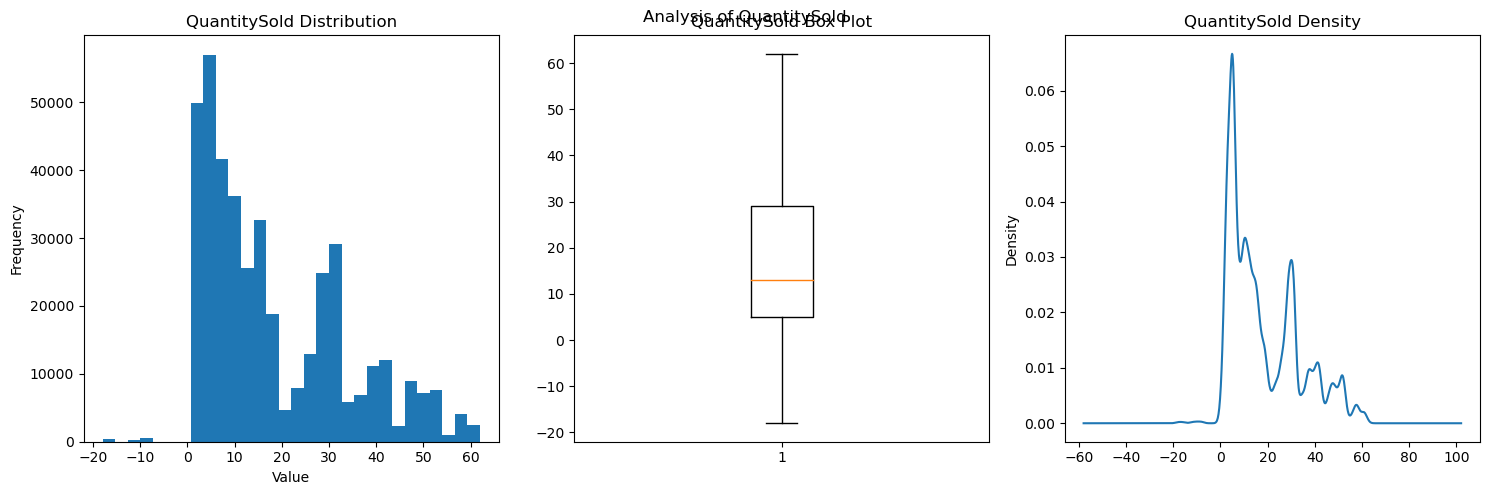

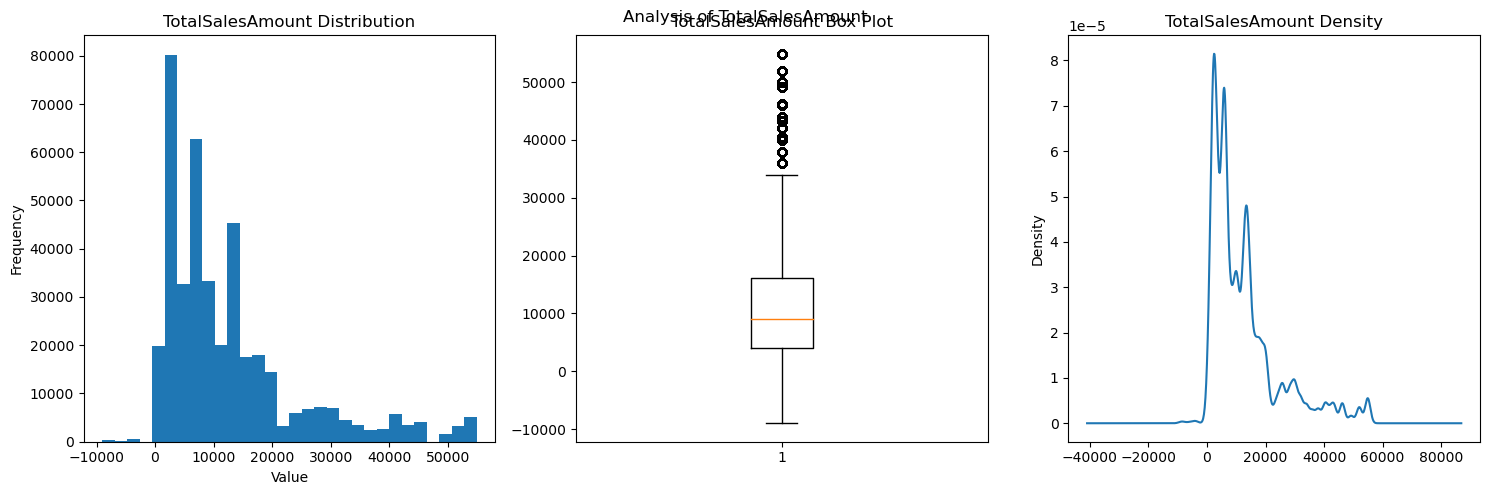

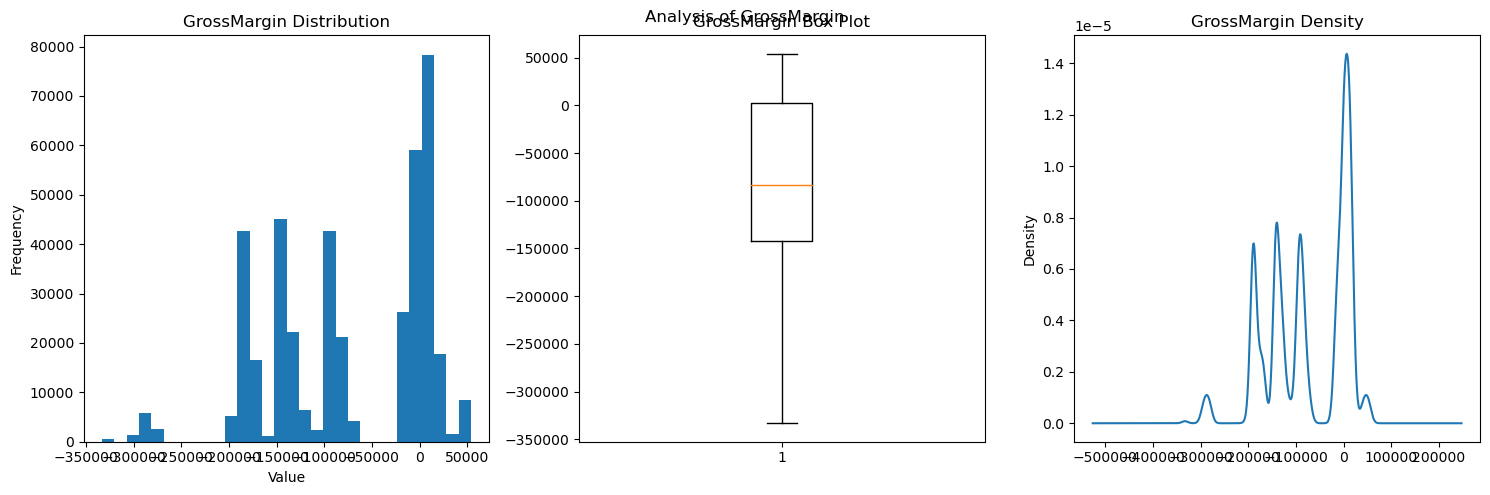


--- Analysis for QuantitySold ---

Top 5 Correlations:
QuantitySold             1.000000
CustomerCreditMax        0.472740
CustomerID               0.468762
TotalSalesAmount         0.436289
IsHighTurnoverProduct    0.433800
Name: QuantitySold, dtype: float64

Top 5 Mutual Information Scores:
GrossMarginPercentage    3.486959
CostOfSalesRatio         3.484931
row_id                   3.440436
SoldToPurchasedRatio     3.434149
InventoryEfficiency      3.433033
dtype: float64

Skewness: 0.8761294887259583
Variance: 226.73735105022064

Summary Statistics:
count    411836.000000
mean         18.288353
std          15.057800
min         -18.000000
25%           5.000000
50%          13.000000
75%          29.000000
max          62.000000
Name: QuantitySold, dtype: float64

--- Analysis for TotalSalesAmount ---

Top 5 Correlations:
TotalSalesAmount    1.000000
SalesPrice          0.590470
PriceRatio          0.534050
PurchasePrice       0.438570
QuantitySold        0.436289
Name: TotalSales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder

def clean_dataframe(df):
    # Create a copy to avoid modifying the original DataFrame
    cleaned_df = df.copy()
    
    # Identify and encode categorical columns
    categorical_cols = cleaned_df.select_dtypes(include=['object']).columns
    label_encoder = LabelEncoder()
    
    for col in categorical_cols:
        try:
            cleaned_df[col] = label_encoder.fit_transform(cleaned_df[col].astype(str))
        except:
            print(f"Could not encode column: {col}")
    
    # Convert all columns to numeric, coercing errors to NaN
    numeric_cols = cleaned_df.select_dtypes(include=['object']).columns
    for col in numeric_cols:
        cleaned_df[col] = pd.to_numeric(cleaned_df[col], errors='coerce')
    
    # Drop columns with all NaN values after conversion
    cleaned_df.dropna(axis=1, how='all', inplace=True)
    
    return cleaned_df

def analyze_target_column(df, potential_targets):
    # Clean the DataFrame first
    df_cleaned = clean_dataframe(df)
    
    # Analysis criteria
    analysis_results = {}
    
    for target in potential_targets:
        # 1. Correlation Analysis
        correlations = df_cleaned.corr()[target].abs().sort_values(ascending=False)
        
        # 2. Mutual Information Score

        # Exclude non-numeric columns and the targets themselves
        numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
        X = df_cleaned[numeric_cols].drop(columns=potential_targets)
        y = df_cleaned[target]
        
        mi_scores = mutual_info_regression(X, y)
        mi_series = pd.Series(mi_scores, index=X.columns)
        
        # 3. Skewness and Distribution
        skewness = y.skew()
        
        # 4. Variance
        variance = y.var()
        
        # 5. Statistical Summary
        summary_stats = y.describe()
        
        analysis_results[target] = {
            'top_correlations': correlations.head(5),
            'mutual_info_top5': mi_series.sort_values(ascending=False).head(5),
            'skewness': skewness,
            'variance': variance,
            'summary_stats': summary_stats
        }
        
        # Visualization
        plt.figure(figsize=(15, 5))
        
        # Histogram
        plt.subplot(131)
        plt.hist(y, bins=30)
        plt.title(f'{target} Distribution')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        
        # Box Plot
        plt.subplot(132)
        plt.boxplot(y)
        plt.title(f'{target} Box Plot')
        
        # Kernel Density Estimation
        plt.subplot(133)
        y.plot(kind='density')
        plt.title(f'{target} Density')
        
        plt.tight_layout()
        plt.suptitle(f'Analysis of {target}')
        plt.show()
    
    return analysis_results

# Usage
dfSales = pd.read_csv("../DataSalesPurchaseFeatured.csv")

# Updated potential targets: focusing on sales metrics
potential_targets = ['QuantitySold', 'TotalSalesAmount', 'GrossMargin']

results = analyze_target_column(dfSales, potential_targets)

# Print detailed results
for target, analysis in results.items():
    print(f"\n--- Analysis for {target} ---")
    print("\nTop 5 Correlations:")
    print(analysis['top_correlations'])
    print("\nTop 5 Mutual Information Scores:")
    print(analysis['mutual_info_top5'])
    print("\nSkewness:", analysis['skewness'])
    print("Variance:", analysis['variance'])
    print("\nSummary Statistics:")
    print(analysis['summary_stats'])



# Data Preprocessing for Purchase Optimization with QuantitySold as target column

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder

# Load the data
dfPurchases = pd.read_csv("../DataSalesPurchaseFeatured.csv")
dfRowId = dfPurchases.copy()


# Common columns to drop
columns_to_drop = [
    "SalesName", "ProductName", "PurchaseName", 
    "VendorTaxGroup", "VendorCurrency", "CustomerPaymentTermID", "PurchaseOrderAccount",
    "VendorGroupAvgPurchase", "CustomerGroupAvgSales", 
    "DeliveryMonthSin", "DeliveryMonthCos", "PriceRatio", "SalesPriceMarkupRatio", "SoldToPurchasedRatio"
]

# Drop specified columns
dfPurchases.drop(columns=[col for col in columns_to_drop if col in dfPurchases.columns], inplace=True)


# Sort and remove duplicates
dfPurchases = dfPurchases.sort_values(by=["PurchaseYear", "PurchaseMonth"], ascending=True)
dfPurchases = dfPurchases.drop_duplicates()

# Categorical Columns Classification
nominal_cols = [
    "CustomerID", "CustomerGroup", "DeliveryMode", 
    "CustomerTaxGroup", "ProductID", 
    "VendorID", "VendorGroup", "PurchaseStatus"
]

ordinal_cols = [
    "CustomerCreditRating", 
    "ProductProfitabilityCategory"
]

binary_cols = [
    "HighCreditRisk", 
    "DeliveryIsWeekend", 
    "PurchaseIsWeekend",
    "IsEndOfFiscalQuarter",
    "IsHighTurnoverProduct"
]


numerical_cols = [
    "CustomerCreditMax", "QuantitySold", "SalesPrice", 
    "TotalSalesAmount", "QuantityPurchased", "PurchasePrice", 
    "TotalPurchaseAmount", "InventoryCostPosted", 
    "InventoryQuantityChange", "DeliveryYear", "DeliveryMonth", 
    "DeliveryQuarter", "DeliveryDayOfWeek", "PurchaseYear", 
    "PurchaseMonth", "PurchaseQuarter", "PurchaseDayOfWeek", 
    "OrderToDeliveryDays", "GrossMargin", "GrossMarginPercentage", 
    "CostOfSalesRatio", "InventoryTurnoverRate", 
    "InventoryCostPerUnit", "CreditUtilizationRatio", 
    "CreditRatingScore", "InventoryEfficiency", "MonthlySalesSeasonality"
]

df_unencodedColumns = dfPurchases[["CustomerID", "ProductID"]].copy()
df_unencodedColumns = df_unencodedColumns.set_index(dfPurchases.index)

# 1. Nominal Categorical Encoding (Target Encoding) using QuantitySold as the target
target_encoder = TargetEncoder(cols=nominal_cols)
dfPurchases[nominal_cols] = target_encoder.fit_transform(
    dfPurchases[nominal_cols], 
    dfPurchases['QuantitySold']
)


# 2. Ordinal Encoding (Label Encoding)
label_encoder = LabelEncoder()
for col in ordinal_cols:
    if col in dfPurchases.columns:
        dfPurchases[col] = label_encoder.fit_transform(dfPurchases[col].astype(str))


# 3. Binary Encoding (0/1)
for col in binary_cols:
    if col in dfPurchases.columns:
        dfPurchases[col] = dfPurchases[col].map({'Yes': 1, 'No': 0, 1: 1, 0: 0})


# Display information about the processed dataframe
print(f"DataFrame shape: {dfPurchases.shape}")
print("\nFirst 5 rows:")
print(dfPurchases.head())


# Set display option for all columns
pd.set_option('display.max_columns', None)


DataFrame shape: (411836, 44)

First 5 rows:
     row_id  CustomerID  CustomerCreditMax  CustomerCreditRating  \
907     907   10.598654           250000.0                     1   
908     908   10.598654           250000.0                     1   
909     909   10.598654           250000.0                     1   
910     910   10.598654           250000.0                     1   
911     911   10.598654           250000.0                     1   

     CustomerGroup  DeliveryMode  CustomerTaxGroup  ProductID  QuantitySold  \
907      15.157883     18.288353          8.907401  21.661157         -16.0   
908      15.157883     18.288353          8.907401  21.661157         -16.0   
909      15.157883     18.288353          8.907401  21.661157         -16.0   
910      15.157883     18.288353          8.907401  21.661157         -16.0   
911      15.157883     18.288353          8.907401  21.661157         -16.0   

     SalesPrice  TotalSalesAmount  PurchaseStatus   VendorID  VendorGro

# Look for high correlations between QuantitySold and other variables.

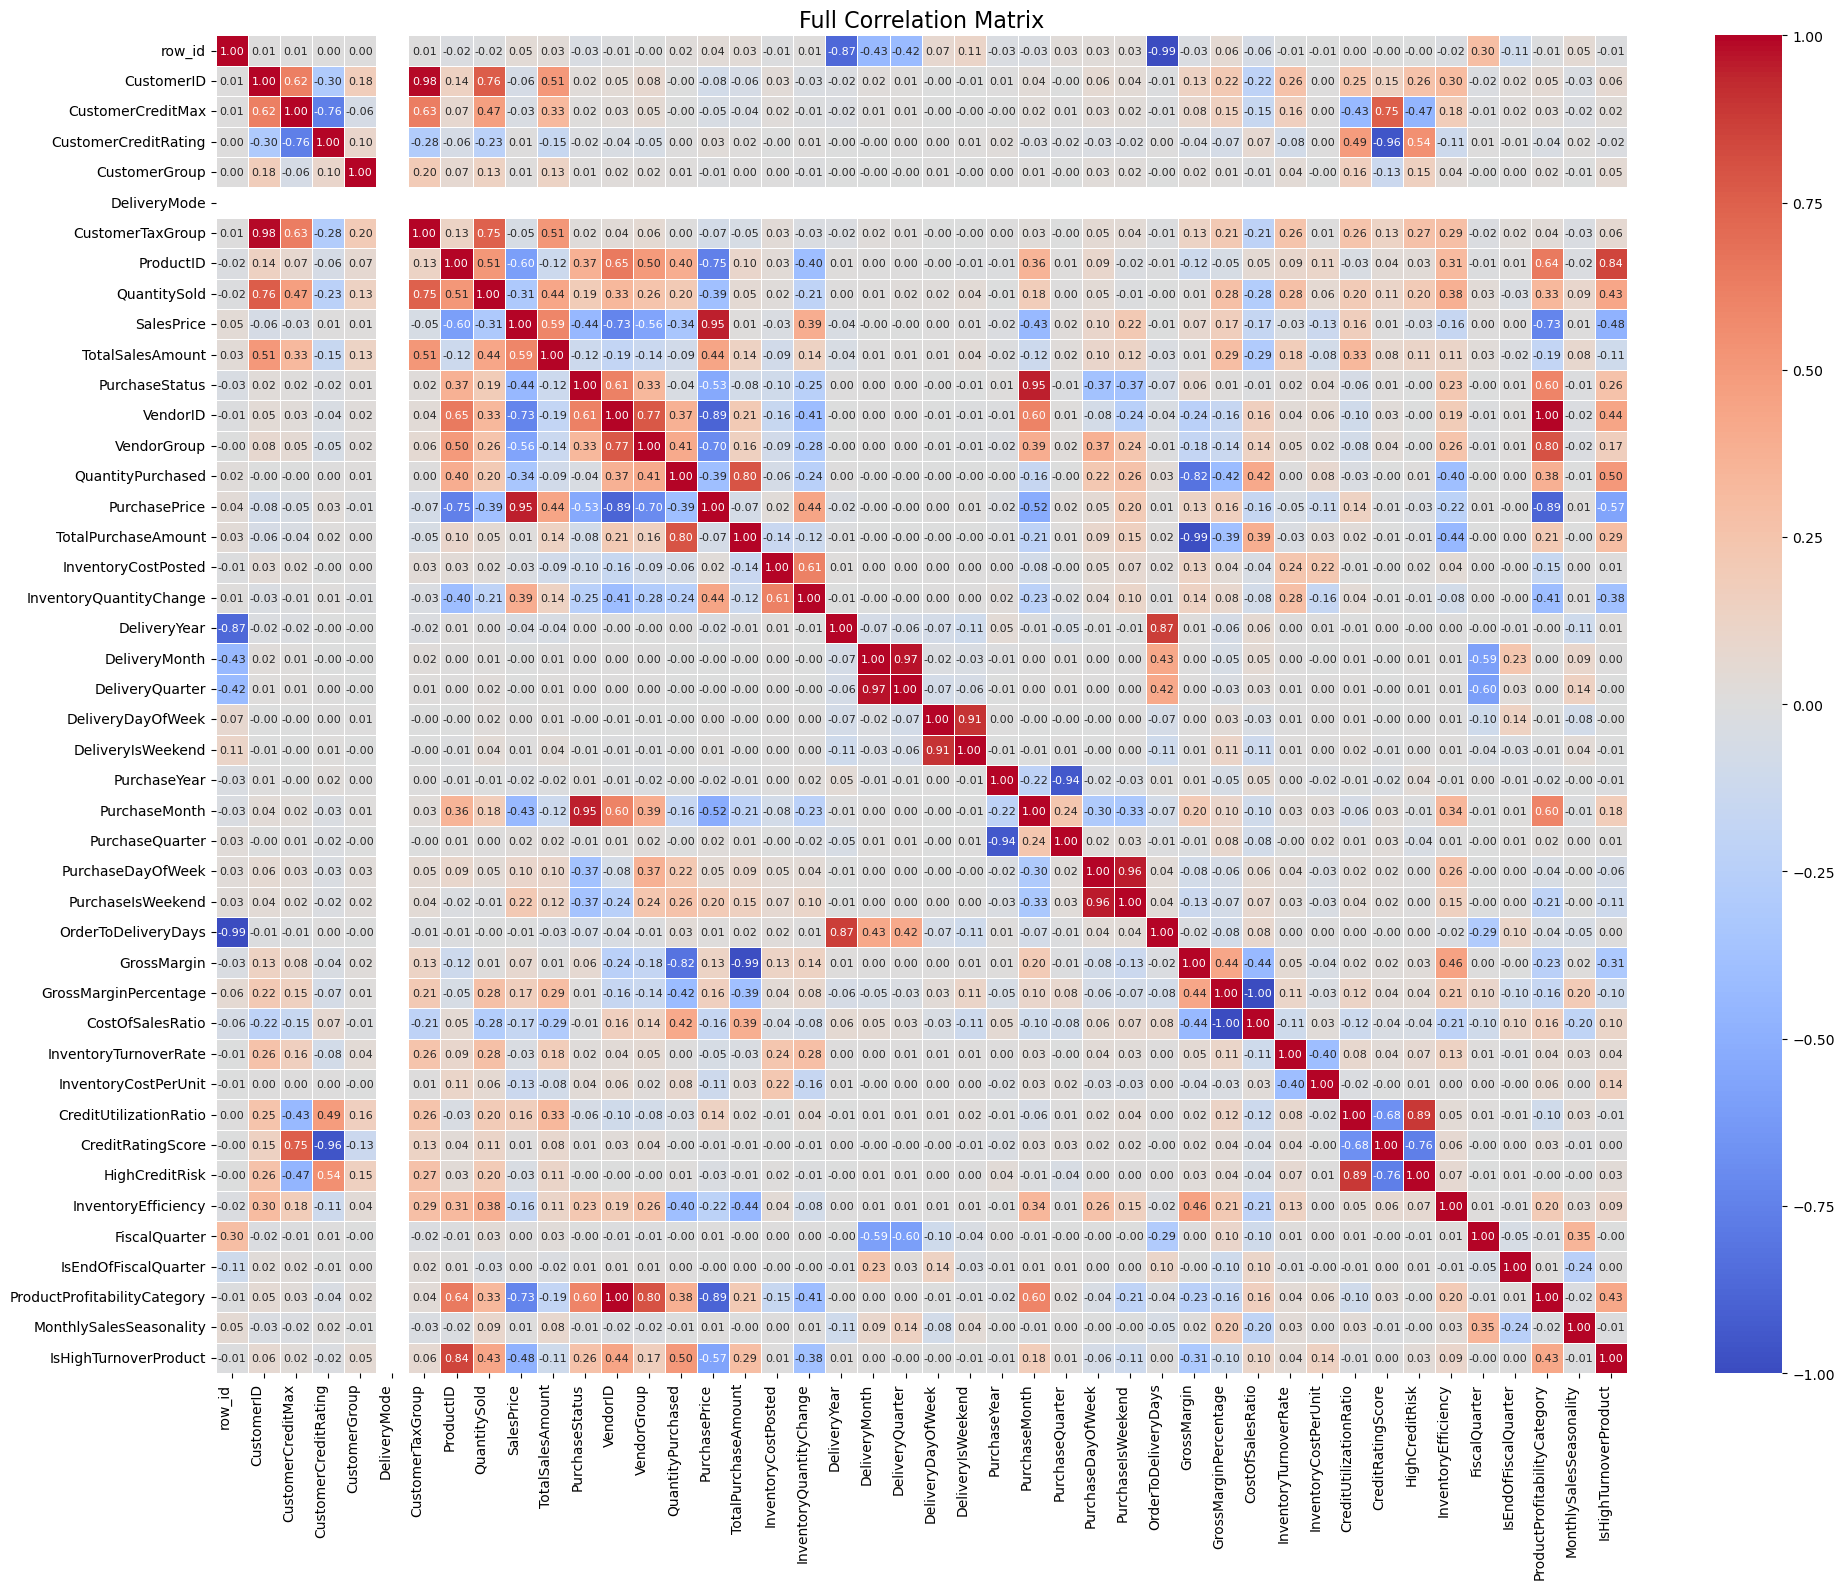

High Correlation Pairs (|correlation| > 0.75):
                  Feature 1                     Feature 2  Correlation
435                VendorID  ProductProfitabilityCategory     0.998715
45               CustomerID              CustomerTaxGroup     0.984472
627           DeliveryMonth               DeliveryQuarter     0.971137
767       PurchaseDayOfWeek             PurchaseIsWeekend     0.960732
313              SalesPrice                 PurchasePrice     0.950310
388          PurchaseStatus                 PurchaseMonth     0.947359
672       DeliveryDayOfWeek             DeliveryIsWeekend     0.905747
868  CreditUtilizationRatio                HighCreditRisk     0.887811
612            DeliveryYear           OrderToDeliveryDays     0.869309
272               ProductID         IsHighTurnoverProduct     0.843892
465             VendorGroup  ProductProfitabilityCategory     0.804479
469       QuantityPurchased           TotalPurchaseAmount     0.796459
407                VendorID   

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Compute the full correlation matrix for numeric columns
corr_matrix = dfPurchases.corr(numeric_only=True)

# Plot the full correlation matrix with adjusted formatting
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
            annot_kws={"size": 8}, linewidths=0.5)
plt.xticks(rotation=90, ha="right")
plt.yticks(rotation=0)
plt.title("Full Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()

# Extract upper triangle of the correlation matrix (excluding self-correlation)
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper_triangle = corr_matrix.where(mask)

# Convert to long format and filter correlations with absolute value > 0.75
high_corr_pairs = (
    upper_triangle.stack()
    .reset_index()
    .rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Correlation"})
    .query("abs(Correlation) > 0.75")
    .sort_values(by="Correlation", ascending=False)
)

# Display high correlation pairs for all features
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

print("High Correlation Pairs (|correlation| > 0.75):")
print(high_corr_pairs)

# Additionally, extract and display features highly correlated with the target 'QuantitySold'
target_corr = corr_matrix['QuantitySold'].abs().sort_values(ascending=False)
high_corr_with_target = target_corr[target_corr > 0.75]

print("\nFeatures with |correlation| > 0.75 with QuantitySold:")
print(high_corr_with_target)


## Delete columns with high corr 

In [5]:
# List of columns to drop based on high-correlation analysis
columns_to_drop = [
    # Redundant calculation columns
    'VendorGroupAvgPurchase',
    'CustomerGroupAvgSales',
    'DeliveryMonthSin',
    'DeliveryMonthCos',
    'CostOfSalesRatio',         # Perfect correlation with PurchaseToSalesRatio (1.0) and perfectly (negatively) correlated with GrossMarginPercentage
    'SoldToPurchasedRatio',
    'SalesPriceMarkupRatio',
    'PriceRatio',
    
    # Redundant features based on high correlations
    'GrossMarginPercentage',    # Perfect negative correlation with CostOfSalesRatio (-1.0)
    'DeliveryQuarter',          # High correlation with DeliveryMonth (0.97)
    'DeliveryIsWeekend',        # High correlation with DeliveryDayOfWeek (0.91)
    'PurchaseIsWeekend',        # High correlation with PurchaseDayOfWeek (0.96)
    'PurchaseQuarter',          # High correlation with PurchaseYear (-0.94)
    'HighCreditRisk',           # High correlation with CreditUtilizationRatio (0.89)
    'CreditRatingScore',        # High correlation with CustomerCreditRating (-0.96)
    'GrossMargin',              # Redundant with other margin related metrics
    
    # Other redundant or non-predictive columns
    'VendorTaxGroup',
    'VendorCurrency',
    'PurchaseOrderAccount',
    'PurchaseName',
    'ProductName',
    'SalesName',
    
    'ProductProfitabilityCategory',
    'DeliveryYear',
    'TotalPurchaseAmount',
    'CustomerTaxGroup',
    'VendorGroup',
    'CustomerCreditMax',
    'PurchasePrice',
    'PurchaseStatus',
    'IsHighTurnoverProduct'
]

# Ensure only existing columns are dropped (and keep QuantitySold intact)
columns_to_drop = [col for col in columns_to_drop if col in dfPurchases.columns]

# Create a cleaned dataframe with redundant columns removed
dfSales_cleaned = dfPurchases.drop(columns=columns_to_drop)

print(f"Dropped {len(columns_to_drop)} columns. Remaining columns: {dfSales_cleaned.shape[1]}")
print("Columns were deleted successfully!")


Dropped 18 columns. Remaining columns: 26
Columns were deleted successfully!


## Check Corr again

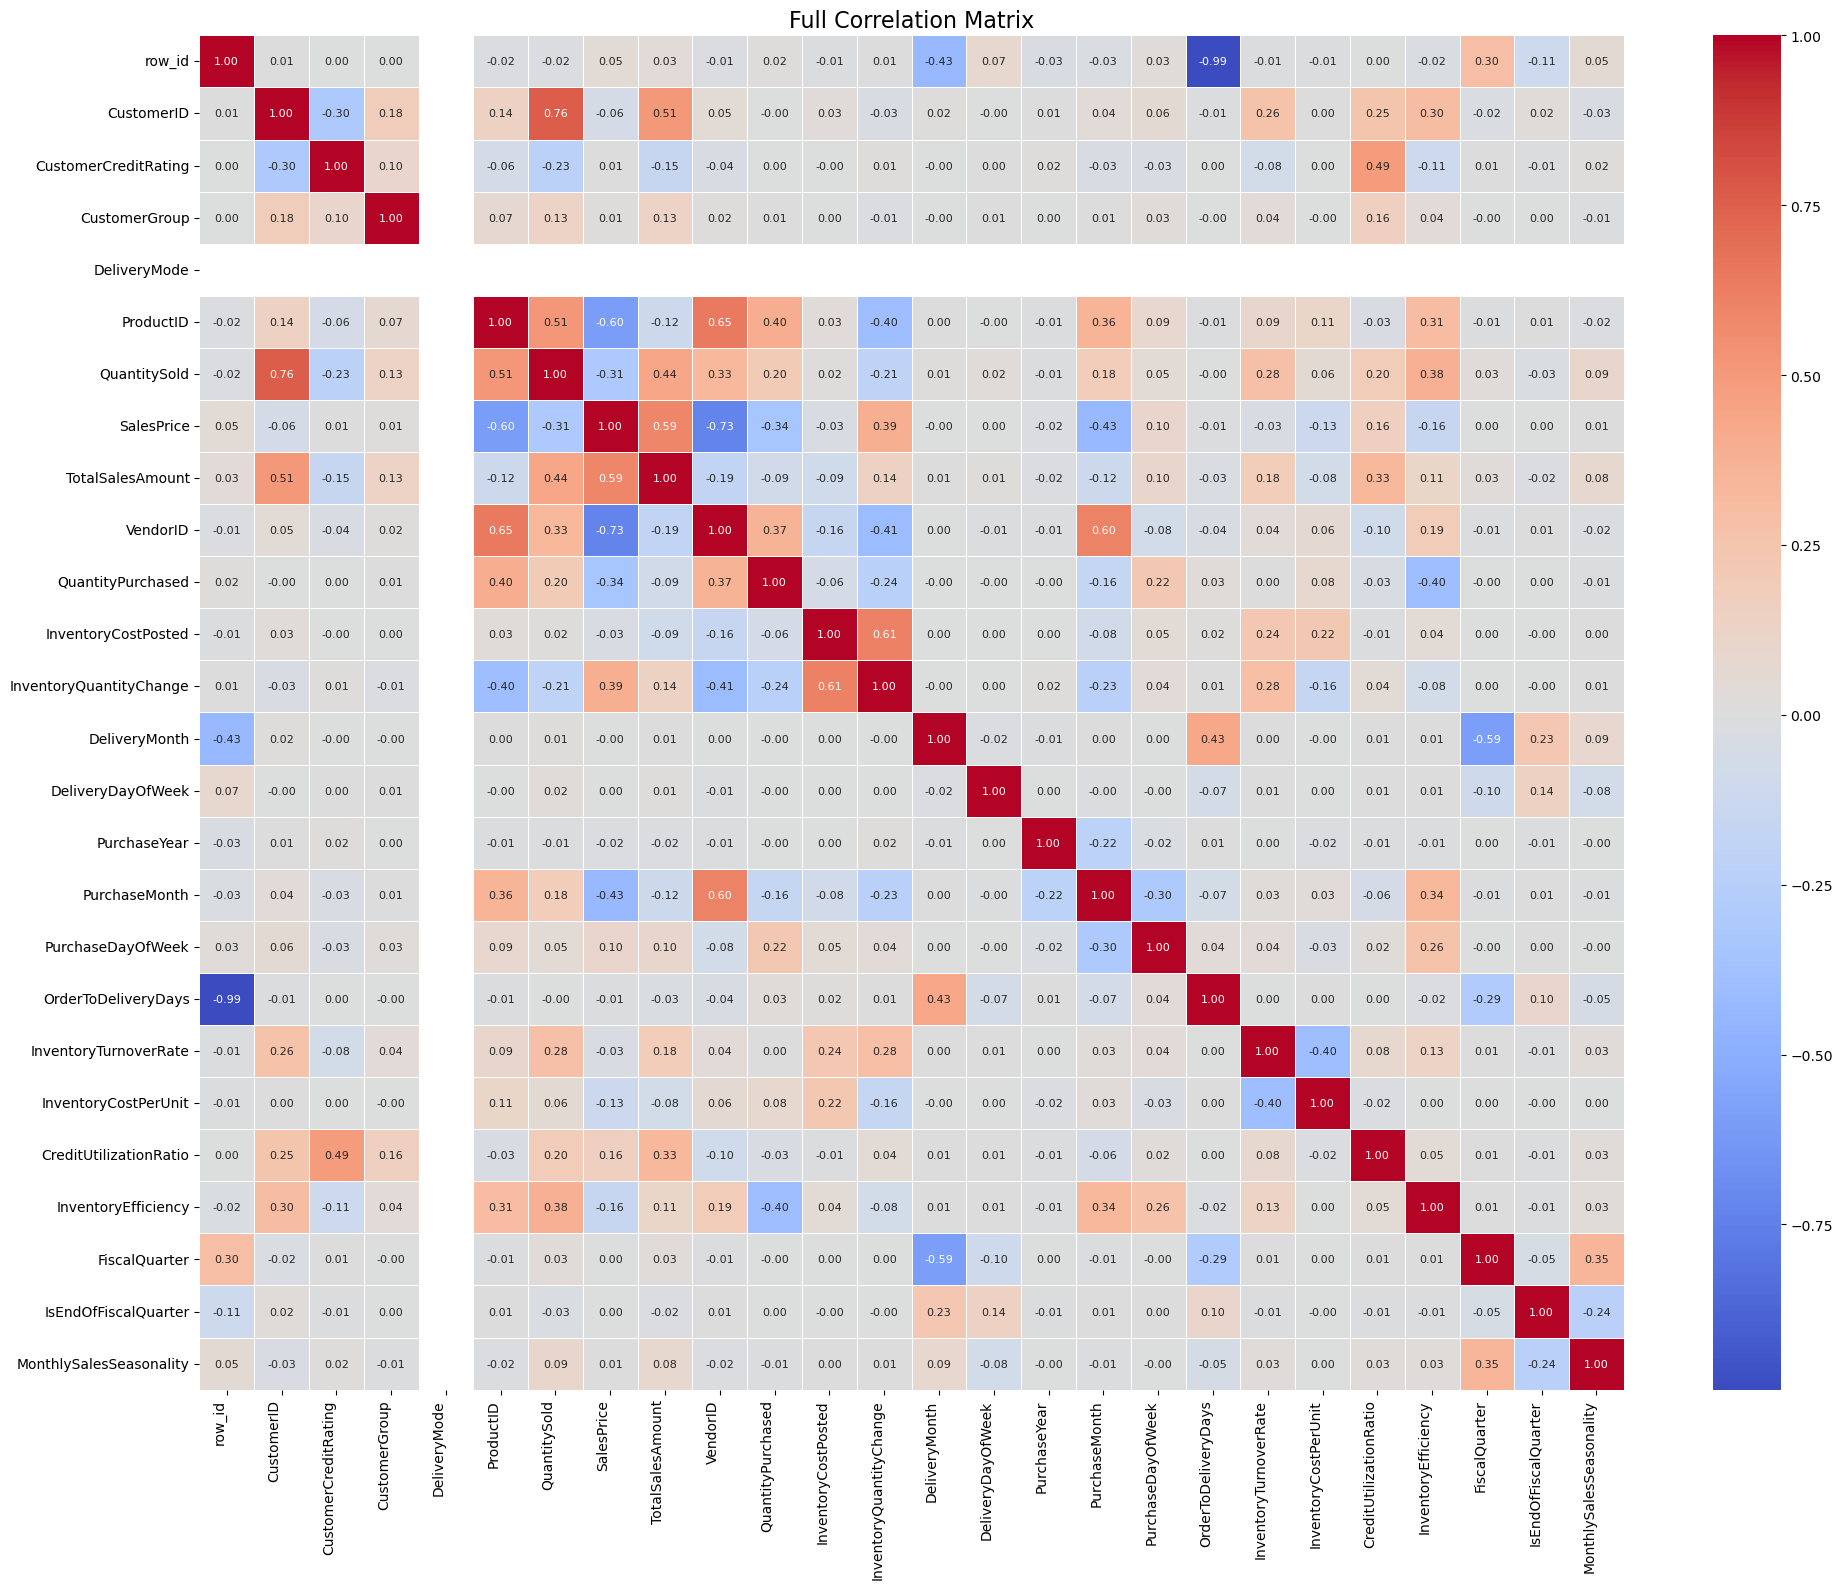

High Correlation Pairs (|correlation| > 0.75):
     Feature 1            Feature 2  Correlation
27  CustomerID         QuantitySold     0.760391
16      row_id  OrderToDeliveryDays    -0.993116

Features with |correlation| > 0.75 with QuantitySold:
QuantitySold    1.000000
CustomerID      0.760391
Name: QuantitySold, dtype: float64


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Compute the full correlation matrix for numeric columns
corr_matrix = dfSales_cleaned.corr(numeric_only=True)

# Plot the full correlation matrix with adjusted formatting
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
            annot_kws={"size": 8}, linewidths=0.5)
plt.xticks(rotation=90, ha="right")
plt.yticks(rotation=0)
plt.title("Full Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()

# Extract upper triangle of the correlation matrix (excluding self-correlation)
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper_triangle = corr_matrix.where(mask)

# Convert to long format and filter correlations with absolute value > 0.75
high_corr_pairs = (
    upper_triangle.stack()
    .reset_index()
    .rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Correlation"})
    .query("abs(Correlation) > 0.75")
    .sort_values(by="Correlation", ascending=False)
)

# Display high correlation pairs for all features
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

print("High Correlation Pairs (|correlation| > 0.75):")
print(high_corr_pairs)

# Additionally, extract and display features highly correlated with the target 'QuantitySold'
target_corr = corr_matrix['QuantitySold'].abs().sort_values(ascending=False)
high_corr_with_target = target_corr[target_corr > 0.75]

print("\nFeatures with |correlation| > 0.75 with QuantitySold:")
print(high_corr_with_target)


In [7]:
dfSales_cleaned.head()



row_id  CustomerID  CustomerCreditRating  CustomerGroup  DeliveryMode  \
907     907   10.598654                     1      15.157883     18.288353   
908     908   10.598654                     1      15.157883     18.288353   
909     909   10.598654                     1      15.157883     18.288353   
910     910   10.598654                     1      15.157883     18.288353   
911     911   10.598654                     1      15.157883     18.288353   

     ProductID  QuantitySold  SalesPrice  TotalSalesAmount   VendorID  \
907  21.661157         -16.0       500.0           -8000.0  20.729883   
908  21.661157         -16.0       500.0           -8000.0  20.729883   
909  21.661157         -16.0       500.0           -8000.0  20.729883   
910  21.661157         -16.0       500.0           -8000.0  20.729883   
911  21.661157         -16.0       500.0           -8000.0  20.729883   

     QuantityPurchased  InventoryCostPosted  InventoryQuantityChange  \
907              650.0             -19800.0                    -66.0   
908              650.0             -19500.0                    -65.0   
909              650.0             -18900.0                    -63.0   
910              650.0             -18600.0                    -62.0   
911              650.0             -18300.0                    -61.0   

     DeliveryMonth  DeliveryDayOfWeek  PurchaseYear  PurchaseMonth  \
907              1                  0          2016             11   
908              1                  0          2016             11   
909              1                  0          2016             11   
910              1                  0          2016             11   
911              1                  0          2016             11   

     PurchaseDayOfWeek  OrderToDeliveryDays  InventoryTurnoverRate  \
907                  6                   71              -0.242424   
908                  6                   71              -0.246154   
909                  6                   71              -0.253968   
910                  6                   71              -0.258065   
911                  6                   71              -0.262295   

     InventoryCostPerUnit  CreditUtilizationRatio  InventoryEfficiency  \
907                -300.0                  -0.032            -0.024615   
908                -300.0                  -0.032            -0.024615   
909                -300.0                  -0.032            -0.024615   
910                -300.0                  -0.032            -0.024615   
911                -300.0                  -0.032            -0.024615   

     FiscalQuarter  IsEndOfFiscalQuarter  MonthlySalesSeasonality  
907              3                     0                 0.479942  
908              3                     0                 0.479942  
909              3                     0                 0.479942  
910              3                     0                 0.479942  
911              3                     0                 0.479942

## My Columns 

In [8]:
# Define a mapping for the specific columns to rename
rename_mapping = {
    "PurchaseYear": "SalesYear",
    "PurchaseMonth": "SalesMonth",
    "PurchaseDayOfWeek": "SalesDayOfWeek"
}

# Rename the columns in the DataFrame
dfSales_cleaned.rename(columns=rename_mapping, inplace=True)

# Verify the changes by printing the updated column names
print("Updated DataFrame Columns:")
print(dfSales_cleaned.columns)


Updated DataFrame Columns:
Index(['row_id', 'CustomerID', 'CustomerCreditRating', 'CustomerGroup',
       'DeliveryMode', 'ProductID', 'QuantitySold', 'SalesPrice',
       'TotalSalesAmount', 'VendorID', 'QuantityPurchased',
       'InventoryCostPosted', 'InventoryQuantityChange', 'DeliveryMonth',
       'DeliveryDayOfWeek', 'SalesYear', 'SalesMonth', 'SalesDayOfWeek',
       'OrderToDeliveryDays', 'InventoryTurnoverRate', 'InventoryCostPerUnit',
       'CreditUtilizationRatio', 'InventoryEfficiency', 'FiscalQuarter',
       'IsEndOfFiscalQuarter', 'MonthlySalesSeasonality'],
      dtype='object')


# Check date distribution

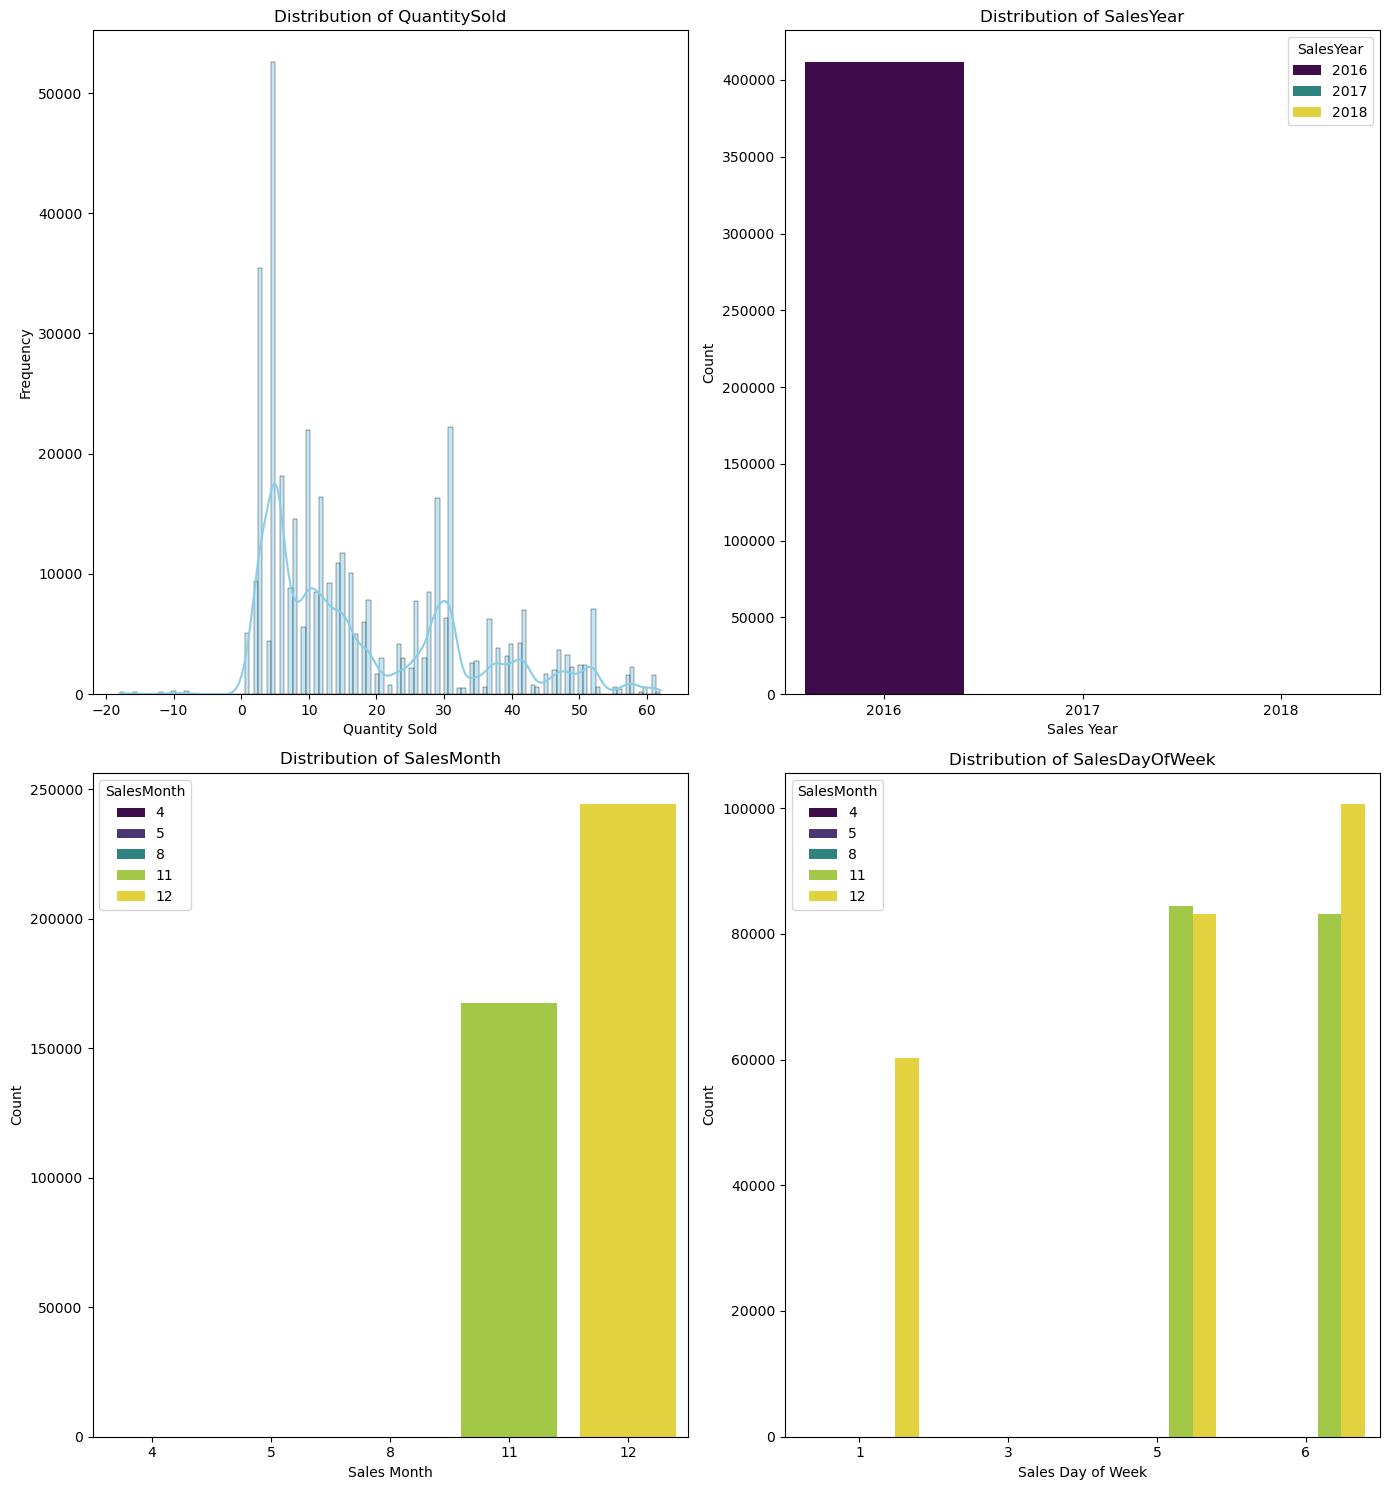

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots for each column distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 15))

# 1. Distribution of QuantitySold (Target Variable)
sns.histplot(dfSales_cleaned['QuantitySold'], kde=True, ax=axes[0, 0], color="skyblue")
axes[0, 0].set_title('Distribution of QuantitySold')
axes[0, 0].set_xlabel('Quantity Sold')
axes[0, 0].set_ylabel('Frequency')

# 2. Distribution of SalesYear
sns.countplot(x='SalesYear', data=dfSales_cleaned, hue='SalesYear', ax=axes[0, 1], palette="viridis")
axes[0, 1].set_title('Distribution of SalesYear')
axes[0, 1].set_xlabel('Sales Year')
axes[0, 1].set_ylabel('Count')

# 3. Distribution of SalesMonth
sns.countplot(x='SalesMonth', data=dfSales_cleaned,hue='SalesMonth', ax=axes[1, 0], palette="viridis")
axes[1, 0].set_title('Distribution of SalesMonth')
axes[1, 0].set_xlabel('Sales Month')
axes[1, 0].set_ylabel('Count')

# 4. Distribution of SalesDayOfWeek
sns.countplot(x='SalesDayOfWeek', data=dfSales_cleaned,hue='SalesMonth', ax=axes[1, 1], palette="viridis")
axes[1, 1].set_title('Distribution of SalesDayOfWeek')
axes[1, 1].set_xlabel('Sales Day of Week')
axes[1, 1].set_ylabel('Count')


plt.tight_layout()
plt.show()


# Generate Dates between 2015-2020


Sample of updated data:
     sale_date  SaleYear  SaleMonth  SaleQuarter  SaleDayOfWeek  \
907 2017-01-21      2017          1            1              5   
908 2016-09-12      2016          9            3              0   
909 2019-12-10      2019         12            4              1   
910 2020-08-24      2020          8            3              0   
911 2015-09-09      2015          9            3              2   

     SaleIsWeekend  SaleWeekOfMonth  
907              1                4  
908              0                3  
909              0                3  
910              0                5  
911              0                2  


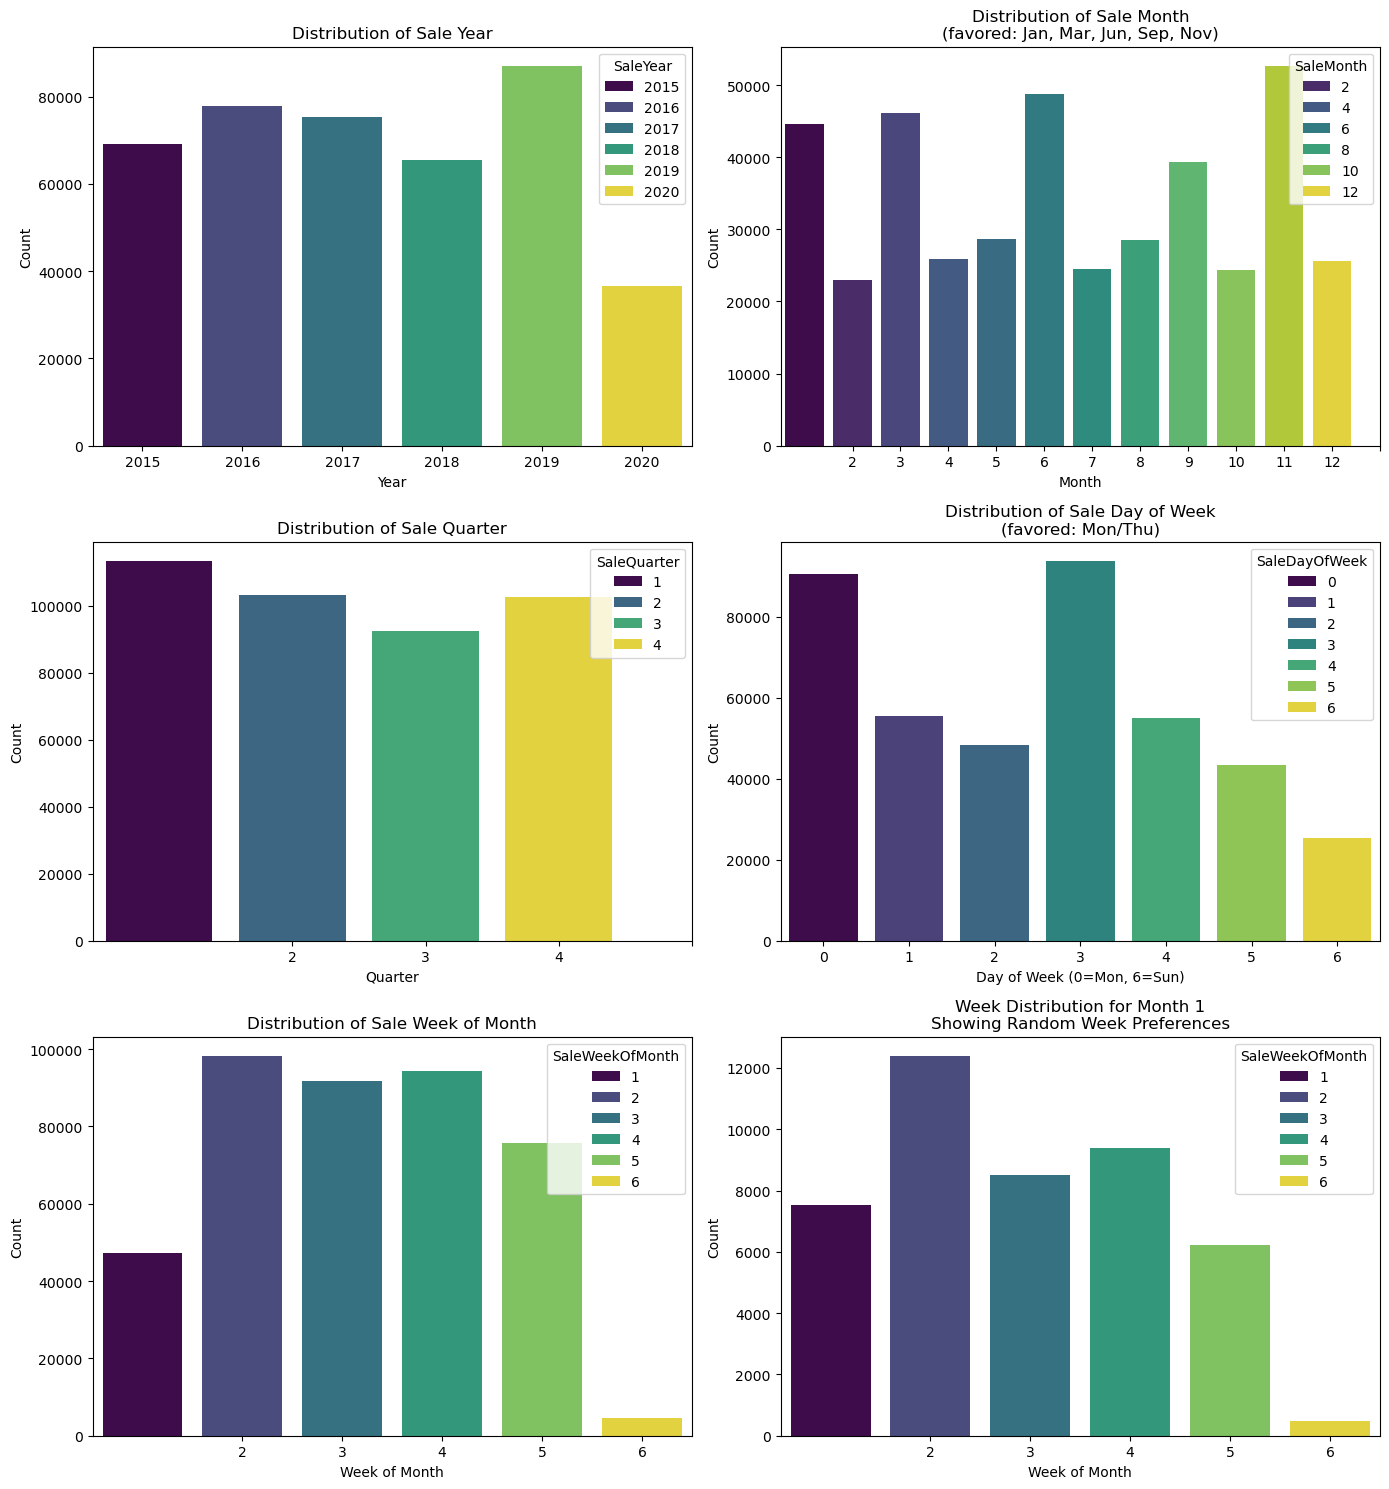


Final Test Dataset:
Date range: 2020-01-01 to 2020-12-31
Shape: (36681, 33)
Percentage of original data: 9.78%


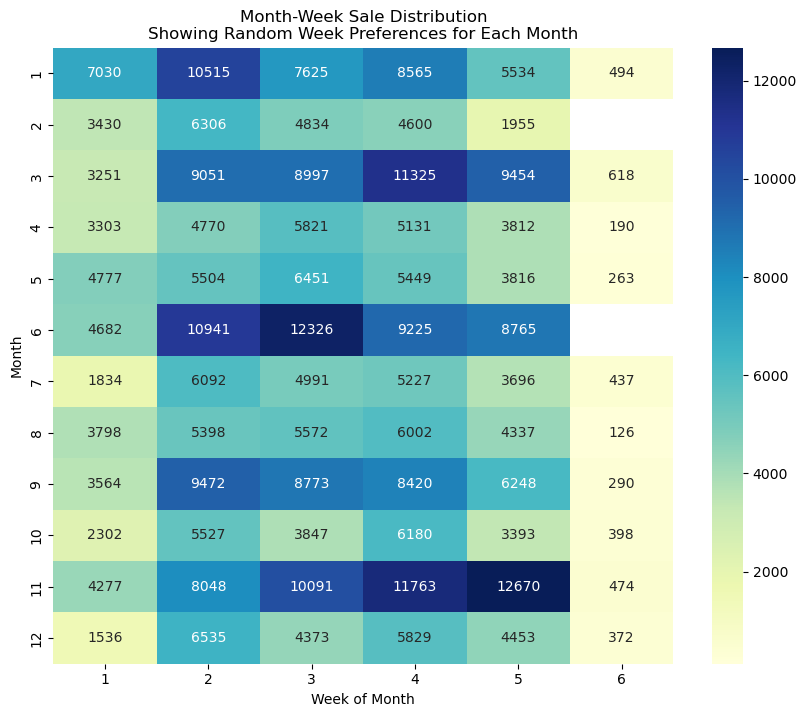

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set seed for reproducibility
np.random.seed(42)

# Use dfSales_cleaned (input DataFrame) and default range.
start_date = pd.to_datetime("2015-01-01")
end_date = pd.to_datetime("2020-12-31")

# Generate full date range based on the defined timeframe
date_range = pd.date_range(start=start_date, end=end_date, freq="D")

# Base weights for weekdays and months (common baseline)
base_weekday_weights = {i: 1 for i in range(7)}
base_weekday_weights.update({0: 1.52, 3: 1.68, 5: 0.82, 6: 0.51})  # Favor Monday and Thursday; lower for Sat & Sun

# Instead of using varied base_month_weights, we now use a basic version which will be further adjusted.
basic_month_weights = {i: 1 for i in range(1, 13)}

# Define favored months and a favor coefficient
favored_months = [1, 3, 6, 9, 11]
month_favor = {m: (1.5 if m in favored_months else 1.0) for m in range(1, 13)}

# Define year weights as provided
year_weights = {
    2015: 1.27,
    2016: 1.54,
    2017: 1.35,
    2018: 1.28,
    2019: 1.43,
    2020: 0.65   # Lower weight for testing data
}

# Identify all unique years from the input data (or use default years)
years = list(range(2015, 2021))

# Create year-specific weights with increased variation (±25%) for weekday, and random variation for month and week-of-month.
year_weekday_weights = {}
year_month_weights = {}
year_week_weights_by_month = {}

for year in years:
    # Vary weekday weights by ±25%
    year_weekday_weights[year] = {d: base_weekday_weights[d] * np.random.uniform(0.75, 1.25) for d in range(7)}
    # Vary basic month weights by ±25%
    year_month_weights[year] = {m: basic_month_weights[m] * np.random.uniform(0.75, 1.55) for m in range(1, 13)}
    
    # Generate dynamic week preferences per month with a year-specific seed
    np.random.seed(123 + year)  # Different seed per year for week preferences
    month_week_weights = {}
    for month in range(1, 13):
        base_weights = np.ones(5)  # Assume up to 5 weeks in a month
        num_favored = np.random.choice([1, 2])
        favored_weeks = np.random.choice(5, size=num_favored, replace=False)
        for week in favored_weeks:
            base_weights[week] *= np.random.uniform(1.5, 2.5)
        base_weights /= base_weights.sum()  # Normalize to sum to 1
        month_week_weights[month] = base_weights
    year_week_weights_by_month[year] = month_week_weights

# Function to compute week of month (1-indexed)
def get_week_of_month(date):
    first_day = date.replace(day=1)
    return ((date.day + first_day.weekday()) - 1) // 7 + 1

# Build arrays for each date in date_range using year-specific weights:
year_weights_arr = np.array([year_weights[d.year] for d in date_range])
weekday_weights_arr = np.array([year_weekday_weights[d.year][d.weekday()] for d in date_range])
# For months, multiply the random variation by the constant month favor coefficient.
month_weights_arr = np.array([
    year_month_weights[d.year][d.month] * month_favor[d.month] for d in date_range
])
week_of_month_weights = np.array([
    year_week_weights_by_month[d.year][d.month][min(get_week_of_month(d), 5) - 1] for d in date_range
])

# Combine all weights and normalize
weights = weekday_weights_arr * month_weights_arr * year_weights_arr * week_of_month_weights

# ----- PROMOTIONAL PERIODS / EVENTS -----
# Example 1: Annual Promotion (e.g., Nov 25 - Nov 30 each year)
promo_multiplier = 2.0
promo_mask = np.zeros(len(date_range), dtype=bool)
for year in years:
    promo_start = datetime(year, 11, 25)
    promo_end = datetime(year, 11, 30)
    promo_mask |= ((date_range >= promo_start) & (date_range <= promo_end))

# Example 2: Mid-year Sale (e.g., Jun 15 - Jun 20 each year)
midyear_multiplier = 1.8
midyear_mask = np.zeros(len(date_range), dtype=bool)
for year in years:
    mid_start = datetime(year, 6, 15)
    mid_end = datetime(year, 6, 20)
    midyear_mask |= ((date_range >= mid_start) & (date_range <= mid_end))

# Apply promotional multipliers
weights[promo_mask] *= promo_multiplier
weights[midyear_mask] *= midyear_multiplier

# ----- SPECIAL DATES ADJUSTMENT -----
#   - Black Friday (4th Thursday of November + 1 day)
#   - First Monday of each month
special_dates_mask = np.zeros(len(date_range), dtype=bool)
for year in years:
    nov_first = datetime(year, 11, 1)
    offset_days = (3 - nov_first.weekday()) % 7  # Days until first Thursday
    black_friday = nov_first + pd.Timedelta(days=offset_days + 21 + 1)  # 4th Thursday + 1 day
    idx = np.where(date_range == black_friday)[0]
    if len(idx) > 0:
        special_dates_mask[idx[0]] = True

for date in date_range:
    if date.weekday() == 0 and 1 <= date.day <= 7:  # First Monday of the month
        idx = np.where(date_range == date)[0]
        if len(idx) > 0:
            special_dates_mask[idx[0]] = True

special_day_multiplier = 1.85
weights = np.where(special_dates_mask, weights * special_day_multiplier, weights)

# Normalize final weights
weights /= weights.sum()

# Copy the input DataFrame to generate new sale dates
dfSales_generated = dfSales_cleaned.copy()
random_indices = np.random.choice(np.arange(len(date_range)), size=len(dfSales_generated), p=weights)
dfSales_generated['sale_date'] = pd.Series(date_range[random_indices])

# Update date-related features in the DataFrame
dfSales_generated['SaleYear'] = dfSales_generated['sale_date'].dt.year
dfSales_generated['SaleMonth'] = dfSales_generated['sale_date'].dt.month
dfSales_generated['SaleQuarter'] = dfSales_generated['sale_date'].dt.quarter
dfSales_generated['SaleDayOfWeek'] = dfSales_generated['sale_date'].dt.dayofweek
dfSales_generated['SaleIsWeekend'] = (dfSales_generated['SaleDayOfWeek'] >= 5).astype(int)
dfSales_generated['SaleWeekOfMonth'] = dfSales_generated['sale_date'].apply(get_week_of_month)

# Display sample of updated data
print("\nSample of updated data:")
print(dfSales_generated[['sale_date', 'SaleYear', 'SaleMonth', 'SaleQuarter', 
                          'SaleDayOfWeek', 'SaleIsWeekend', 'SaleWeekOfMonth']].head())

# Visualization with improved formatting
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# Year distribution
sns.countplot(x="SaleYear", data=dfSales_generated,hue="SaleYear", ax=axes[0, 0], palette="viridis")
axes[0, 0].set_title("Distribution of Sale Year", fontsize=12)
axes[0, 0].set_xlabel("Year")
axes[0, 0].set_ylabel("Count")

# Month distribution
sns.countplot(x="SaleMonth", data=dfSales_generated,hue="SaleMonth", ax=axes[0, 1], palette="viridis")
axes[0, 1].set_title("Distribution of Sale Month\n(favored: Jan, Mar, Jun, Sep, Nov)", fontsize=12)
axes[0, 1].set_xlabel("Month")
axes[0, 1].set_ylabel("Count")
axes[0, 1].set_xticks(range(1, 13))

# Quarter distribution
sns.countplot(x="SaleQuarter", data=dfSales_generated,hue="SaleQuarter", ax=axes[1, 0], palette="viridis")
axes[1, 0].set_title("Distribution of Sale Quarter", fontsize=12)
axes[1, 0].set_xlabel("Quarter")
axes[1, 0].set_ylabel("Count")
axes[1, 0].set_xticks(range(1, 5))

# Day of week distribution
sns.countplot(x="SaleDayOfWeek", data=dfSales_generated,hue="SaleDayOfWeek", ax=axes[1, 1], palette="viridis")
axes[1, 1].set_title("Distribution of Sale Day of Week\n(favored: Mon/Thu)", fontsize=12)
axes[1, 1].set_xlabel("Day of Week (0=Mon, 6=Sun)")
axes[1, 1].set_ylabel("Count")
axes[1, 1].set_xticks(range(7))

# Overall week of month distribution
sns.countplot(x="SaleWeekOfMonth", data=dfSales_generated,hue='SaleWeekOfMonth', ax=axes[2, 0], palette="viridis")
axes[2, 0].set_title("Distribution of Sale Week of Month", fontsize=12)
axes[2, 0].set_xlabel("Week of Month")
axes[2, 0].set_ylabel("Count")
axes[2, 0].set_xticks(range(1, 6))

# Plot one example month to show week preferences
example_month = 1  # For example, January
month_data = dfSales_generated[dfSales_generated["SaleMonth"] == example_month]
sns.countplot(x="SaleWeekOfMonth", data=month_data,hue="SaleWeekOfMonth", ax=axes[2, 1], palette="viridis")
axes[2, 1].set_title(f"Week Distribution for Month {example_month}\nShowing Random Week Preferences", fontsize=12)
axes[2, 1].set_xlabel("Week of Month")
axes[2, 1].set_ylabel("Count")
axes[2, 1].set_xticks(range(1, 6))

plt.tight_layout()
plt.show()

# ---------------

# Create final test set from the latest year in data (2020)
dfFinalTest = dfSales_generated[dfSales_generated['SaleYear'] == 2020].copy()
# Remove 2020 data from dfSales_generated
dfSales_generated = dfSales_generated[dfSales_generated['SaleYear'] != 2020].copy()


# 
print("\nFinal Test Dataset:")
print(f"Date range: {dfFinalTest['sale_date'].min().date()} to {dfFinalTest['sale_date'].max().date()}")
print(f"Shape: {dfFinalTest.shape}")
print(f"Percentage of original data: {100 * len(dfFinalTest) / len(dfSales_generated):.2f}%")

# Create a heatmap to visualize week preferences across all months
pivot_data = dfSales_generated.pivot_table(
    index='SaleMonth', 
    columns='SaleWeekOfMonth', 
    values='SaleYear',  # We use SaleYear just to count occurrences
    aggfunc='count'
)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_data, cmap="YlGnBu", annot=True, fmt="g")
plt.title("Month-Week Sale Distribution\nShowing Random Week Preferences for Each Month")
plt.xlabel("Week of Month")
plt.ylabel("Month")
plt.show()


In [13]:
dfSales_generated.head()

row_id  CustomerID  CustomerCreditRating  CustomerGroup  DeliveryMode  \
907     907   10.598654                     1      15.157883     18.288353   
908     908   10.598654                     1      15.157883     18.288353   
909     909   10.598654                     1      15.157883     18.288353   
911     911   10.598654                     1      15.157883     18.288353   
912     912   10.598654                     1      15.157883     18.288353   

     ProductID  QuantitySold  SalesPrice  TotalSalesAmount   VendorID  \
907  21.661157         -16.0       500.0           -8000.0  20.729883   
908  21.661157         -16.0       500.0           -8000.0  20.729883   
909  21.661157         -16.0       500.0           -8000.0  20.729883   
911  21.661157         -16.0       500.0           -8000.0  20.729883   
912  21.661157         -16.0       500.0           -8000.0  20.729883   

     QuantityPurchased  InventoryCostPosted  InventoryQuantityChange  \
907              650.0             -19800.0                    -66.0   
908              650.0             -19500.0                    -65.0   
909              650.0             -18900.0                    -63.0   
911              650.0             -18300.0                    -61.0   
912              650.0             -18000.0                    -60.0   

     DeliveryMonth  DeliveryDayOfWeek  SalesYear  SalesMonth  SalesDayOfWeek  \
907              1                  0       2016          11               6   
908              1                  0       2016          11               6   
909              1                  0       2016          11               6   
911              1                  0       2016          11               6   
912              1                  0       2016          11               6   

     OrderToDeliveryDays  InventoryTurnoverRate  InventoryCostPerUnit  \
907                   71              -0.242424                -300.0   
908                   71              -0.246154                -300.0   
909                   71              -0.253968                -300.0   
911                   71              -0.262295                -300.0   
912                   71              -0.266667                -300.0   

     CreditUtilizationRatio  InventoryEfficiency  FiscalQuarter  \
907                  -0.032            -0.024615              3   
908                  -0.032            -0.024615              3   
909                  -0.032            -0.024615              3   
911                  -0.032            -0.024615              3   
912                  -0.032            -0.024615              3   

     IsEndOfFiscalQuarter  MonthlySalesSeasonality  sale_date  SaleYear  \
907                     0                 0.479942 2017-01-21      2017   
908                     0                 0.479942 2016-09-12      2016   
909                     0                 0.479942 2019-12-10      2019   
911                     0                 0.479942 2015-09-09      2015   
912                     0                 0.479942 2015-06-25      2015   

     SaleMonth  SaleQuarter  SaleDayOfWeek  SaleIsWeekend  SaleWeekOfMonth  
907          1            1              5              1                4  
908          9            3              0              0                3  
909         12            4              1              0                3  
911          9            3              2              0                2  
912          6            2              3              0                4

In [14]:
dfFinalTest.head()

row_id  CustomerID  CustomerCreditRating  CustomerGroup  DeliveryMode  \
910     910   10.598654                     1      15.157883     18.288353   
916     916   10.598654                     1      15.157883     18.288353   
922     922   10.598654                     1      15.157883     18.288353   
950     950   10.598654                     1      15.157883     18.288353   
970     970   10.598654                     1      15.157883     18.288353   

     ProductID  QuantitySold  SalesPrice  TotalSalesAmount   VendorID  \
910  21.661157         -16.0       500.0           -8000.0  20.729883   
916  21.661157         -16.0       500.0           -8000.0  20.729883   
922  21.661157         -16.0       500.0           -8000.0  20.729883   
950  21.661157         -16.0       500.0           -8000.0  20.729883   
970  21.661157         -16.0       500.0           -8000.0  20.729883   

     QuantityPurchased  InventoryCostPosted  InventoryQuantityChange  \
910              650.0             -18600.0                    -62.0   
916              650.0             -16800.0                    -56.0   
922              650.0             -15000.0                    -50.0   
950              650.0              -3600.0                    -12.0   
970              650.0              -6720.0                    -61.0   

     DeliveryMonth  DeliveryDayOfWeek  SalesYear  SalesMonth  SalesDayOfWeek  \
910              1                  0       2016          11               6   
916              1                  0       2016          11               6   
922              1                  0       2016          11               6   
950              1                  0       2016          11               6   
970              1                  0       2016          11               6   

     OrderToDeliveryDays  InventoryTurnoverRate  InventoryCostPerUnit  \
910                   71              -0.258065           -300.000000   
916                   71              -0.285714           -300.000000   
922                   71              -0.320000           -300.000000   
950                   71              -1.333333           -300.000000   
970                   71              -0.262295           -110.163934   

     CreditUtilizationRatio  InventoryEfficiency  FiscalQuarter  \
910                  -0.032            -0.024615              3   
916                  -0.032            -0.024615              3   
922                  -0.032            -0.024615              3   
950                  -0.032            -0.024615              3   
970                  -0.032            -0.024615              3   

     IsEndOfFiscalQuarter  MonthlySalesSeasonality  sale_date  SaleYear  \
910                     0                 0.479942 2020-08-24      2020   
916                     0                 0.479942 2020-01-08      2020   
922                     0                 0.479942 2020-11-02      2020   
950                     0                 0.479942 2020-04-08      2020   
970                     0                 0.479942 2020-05-16      2020   

     SaleMonth  SaleQuarter  SaleDayOfWeek  SaleIsWeekend  SaleWeekOfMonth  
910          8            3              0              0                5  
916          1            1              2              0                2  
922         11            4              0              0                2  
950          4            2              2              0                2  
970          5            2              5              1                3

In [15]:
dfSales_generated.drop(columns=['SalesYear',	'SalesMonth',	'SalesDayOfWeek'], inplace=True)
dfFinalTest.drop(columns=['SalesYear',	'SalesMonth',	'SalesDayOfWeek'], inplace=True)


# Split Data in 70-20-10 approach

In [16]:
# First, sort the data by sale_date
dfSales_generated = dfSales_generated.sort_values(by="sale_date")

# Compute sizes
n_total = len(dfSales_generated)
n_train = int(0.7 * n_total)
n_val = int(0.2 * n_total)

# Split the data
train_df = dfSales_generated.iloc[:n_train]
val_df = dfSales_generated.iloc[n_train:n_train + n_val]
test_df = dfSales_generated.iloc[n_train + n_val:]

print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Test set shape:", test_df.shape)

print("Training data date range:", train_df['sale_date'].min(), "to", train_df['sale_date'].max())
print("Validation data date range:", val_df['sale_date'].min(), "to", val_df['sale_date'].max())
print("Test data date range:", test_df['sale_date'].min(), "to", test_df['sale_date'].max())
dfSales_generated.drop(columns=['sale_date'], inplace=True)
dfFinalTest.drop(columns=['sale_date'], inplace=True)

Training set shape: (262608, 30)
Validation set shape: (75031, 30)
Test set shape: (37516, 30)
Training data date range: 2015-01-01 00:00:00 to 2018-07-26 00:00:00
Validation data date range: 2018-07-26 00:00:00 to 2019-07-25 00:00:00
Test data date range: 2019-07-25 00:00:00 to 2019-12-31 00:00:00


In [17]:
print(dfSales_generated.columns)


Index(['row_id', 'CustomerID', 'CustomerCreditRating', 'CustomerGroup',
       'DeliveryMode', 'ProductID', 'QuantitySold', 'SalesPrice',
       'TotalSalesAmount', 'VendorID', 'QuantityPurchased',
       'InventoryCostPosted', 'InventoryQuantityChange', 'DeliveryMonth',
       'DeliveryDayOfWeek', 'OrderToDeliveryDays', 'InventoryTurnoverRate',
       'InventoryCostPerUnit', 'CreditUtilizationRatio', 'InventoryEfficiency',
       'FiscalQuarter', 'IsEndOfFiscalQuarter', 'MonthlySalesSeasonality',
       'SaleYear', 'SaleMonth', 'SaleQuarter', 'SaleDayOfWeek',
       'SaleIsWeekend', 'SaleWeekOfMonth'],
      dtype='object')


In [18]:
dfSales_generated.head()

row_id  CustomerID  CustomerCreditRating  CustomerGroup  DeliveryMode  \
128789  128789   43.098829                     0      15.157883     18.288353   
350418  350418   43.098829                     0      15.157883     18.288353   
16315    16315   24.865607                     0      15.157883     18.288353   
36598    36598   35.616637                     0      19.603753     18.288353   
232363  232363   11.622932                     0      19.603753     18.288353   

        ProductID  QuantitySold  SalesPrice  TotalSalesAmount   VendorID  \
128789  32.247887          52.0       350.0           18200.0  20.729883   
350418  15.032258          38.0       450.0           17100.0  20.729883   
16315   32.247887          37.0       350.0           12950.0  20.729883   
36598   32.247887          58.0       350.0           20300.0  20.729883   
232363  32.247887          25.0       350.0            8750.0  20.729883   

        QuantityPurchased  InventoryCostPosted  InventoryQuantityChange  \
128789              625.0              -6880.0                    -43.0   
350418                2.0               -640.0                     -2.0   
16315               625.0              -9280.0                    -58.0   
36598               625.0              -6080.0                    -38.0   
232363                1.0              -6080.0                    -38.0   

        DeliveryMonth  DeliveryDayOfWeek  OrderToDeliveryDays  \
128789              6                  0                 -146   
350418              4                  0                 -608   
16315              12                  3                    5   
36598              11                  1                    2   
232363             11                  5                 -393   

        InventoryTurnoverRate  InventoryCostPerUnit  CreditUtilizationRatio  \
128789               1.209302                -160.0                0.036400   
350418              19.000000                -320.0                0.034200   
16315                0.637931                -160.0                0.032375   
36598                1.526316                -160.0                0.040600   
232363               0.657895                -160.0                0.025000   

        InventoryEfficiency  FiscalQuarter  IsEndOfFiscalQuarter  \
128789               0.0832              4                     1   
350418              19.0000              4                     0   
16315                0.0592              2                     1   
36598                0.0928              2                     0   
232363              25.0000              2                     0   

        MonthlySalesSeasonality  SaleYear  SaleMonth  SaleQuarter  \
128789                 0.855815      2015          1            1   
350418                 0.839946      2015          1            1   
16315                  0.931734      2015          1            1   
36598                  0.792023      2015          1            1   
232363                 0.792023      2015          1            1   

        SaleDayOfWeek  SaleIsWeekend  SaleWeekOfMonth  
128789              3              0                1  
350418              3              0                1  
16315               3              0                1  
36598               3              0                1  
232363              3              0                1

# Prepare Features and Target for Modeling

### Case Of using all features

In [50]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Define target column
target_column = "QuantitySold"

# Identify numerical features (already encoded)
numerical_features = [
    "SalesPrice", "TotalSalesAmount", "QuantityPurchased", "InventoryCostPosted",
    "InventoryQuantityChange", "OrderToDeliveryDays", "InventoryTurnoverRate",
    "InventoryCostPerUnit", "CreditUtilizationRatio", "InventoryEfficiency",
    "MonthlySalesSeasonality"
]

# Time-based features
time_features = ["SaleYear", "SaleMonth", "SaleQuarter", "SaleDayOfWeek", "SaleWeekOfMonth"]

# Categorical features to be added
categorical_features = [
    "CustomerID", "CustomerCreditRating", "CustomerGroup", "DeliveryMode",
    "ProductID", "VendorID", "FiscalQuarter", "IsEndOfFiscalQuarter", "SaleIsWeekend"
]

# Final feature list (including both numerical and categorical features)
feature_columns = numerical_features + time_features + categorical_features

# Ensure all selected features exist in the dataset
feature_columns = [col for col in feature_columns if col in train_df.columns]

# Print selected features
print(f"Features used for modeling: {feature_columns}")

# Extract features (X) and target (y) for each split
X_train = train_df.loc[:, feature_columns].copy()
y_train = train_df.loc[:, target_column].copy()

X_val   = val_df  .loc[:, feature_columns].copy()
y_val   = val_df  .loc[:, target_column].copy()

X_test  = test_df .loc[:, feature_columns].copy()
y_test  = test_df .loc[:, target_column].copy()

# Standardize numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Print dataset shapes
print(f"\nX_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

print("\nScaling applied to numerical features.")

# Print sample of processed data
print("\nSample of processed training data:")
print(X_train.head())

print("\nFeature engineering complete. Data ready for predictive modeling.")


Features used for modeling: ['SalesPrice', 'TotalSalesAmount', 'QuantityPurchased', 'InventoryCostPosted', 'InventoryQuantityChange', 'OrderToDeliveryDays', 'InventoryTurnoverRate', 'InventoryCostPerUnit', 'CreditUtilizationRatio', 'InventoryEfficiency', 'MonthlySalesSeasonality', 'SaleYear', 'SaleMonth', 'SaleQuarter', 'SaleDayOfWeek', 'SaleWeekOfMonth', 'CustomerID', 'CustomerCreditRating', 'CustomerGroup', 'DeliveryMode', 'ProductID', 'VendorID', 'FiscalQuarter', 'IsEndOfFiscalQuarter', 'SaleIsWeekend']

X_train shape: (262608, 25), y_train shape: (262608,)
X_val shape: (75031, 25), y_val shape: (75031,)
X_test shape: (37516, 25), y_test shape: (37516,)

Scaling applied to numerical features.

Sample of processed training data:
        SalesPrice  TotalSalesAmount  QuantityPurchased  InventoryCostPosted  \
128789   -0.686146          0.471888           1.399136             0.181438   
350418   -0.557271          0.379672          -0.921204             1.102593   
16315    -0.686146 

### Case of reducing features 

In [ ]:
# import pandas as pd
# from sklearn.preprocessing import StandardScaler

# # Define target column
# target_column = "QuantitySold"

# # Identify numerical features (already encoded)
# num_features = [
#     "SalesPrice",  "CreditUtilizationRatio", "InventoryTurnoverRate", "OrderToDeliveryDays",
# #    "QuantityPurchased", "InventoryEfficiency", "TotalSalesAmount",
# #     "InventoryCostPosted",
# #     "InventoryQuantityChange",  
# #     "InventoryCostPerUnit",  
# #     "MonthlySalesSeasonality"
# ]

# # Time-based features
# time_features = ["SaleYear", "SaleMonth", "SaleQuarter", "SaleDayOfWeek", "SaleWeekOfMonth"]

# # Categorical features to be added
# categorical_features = [
#     "CustomerID", "ProductID",  "VendorID", "FiscalQuarter",
# #     "CustomerCreditRating", "CustomerGroup", "DeliveryMode",
# #       "IsEndOfFiscalQuarter", "SaleIsWeekend"
# ]

# # Final feature list (including both numerical and categorical features)
# feature_columns = num_features + time_features + categorical_features

# numerical_features = num_features + categorical_features

# # Ensure all selected features exist in the dataset
# feature_columns = [col for col in feature_columns if col in train_df.columns]

# # Print selected features
# print(f"Features used for modeling: {feature_columns}")

# # Extract features (X) and target (y) for each split
# X_train = train_df.loc[:, feature_columns].copy()
# y_train = train_df.loc[:, target_column].copy()

# X_val   = val_df  .loc[:, feature_columns].copy()
# y_val   = val_df  .loc[:, target_column].copy()

# X_test  = test_df .loc[:, feature_columns].copy()
# y_test  = test_df .loc[:, target_column].copy()

# # Standardize numerical features
# scaler = StandardScaler()
# X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
# X_val[numerical_features] = scaler.transform(X_val[numerical_features])
# X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# # Print dataset shapes
# print(f"\nX_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
# print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
# print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# print("\nScaling applied to numerical features.")

# # Print sample of processed data
# print("\nSample of processed training data:")
# print(X_train.head())

# print("\nFeature engineering complete. Data ready for predictive modeling.")


Features used for modeling: ['SalesPrice', 'CreditUtilizationRatio', 'InventoryTurnoverRate', 'OrderToDeliveryDays', 'SaleYear', 'SaleMonth', 'SaleQuarter', 'SaleDayOfWeek', 'SaleWeekOfMonth', 'CustomerID', 'ProductID', 'VendorID', 'FiscalQuarter']

X_train shape: (262608, 13), y_train shape: (262608,)
X_val shape: (75031, 13), y_val shape: (75031,)
X_test shape: (37516, 13), y_test shape: (37516,)

Scaling applied to numerical features.

Sample of processed training data:
        SalesPrice  CreditUtilizationRatio  InventoryTurnoverRate  \
128789   -0.686146               -0.231545              -0.164294   
350418   -0.557271               -0.241709               3.601684   
16315    -0.686146               -0.250141              -0.285243   
36598    -0.686146               -0.212140              -0.097188   
232363   -0.686146               -0.284215              -0.281017   

        OrderToDeliveryDays  SaleYear  SaleMonth  SaleQuarter  SaleDayOfWeek  \
128789             0.830191

## Preparation for DfFinalTest

In [21]:
# Extract features (same ones used in training)
X_final_test = dfFinalTest.loc[:, feature_columns].copy()
y_final_test = dfFinalTest.loc[:, target_column].copy()

# Apply scaling using the already fitted scaler
X_final_test[numerical_features] = scaler.transform(X_final_test[numerical_features])


# 📌 Models training and choosing

## 1️⃣ Linear Regression (Baseline Model)

Training Linear Regression Model...

Linear Regression Model Results:
Validation R² Score: 0.8390
Test R² Score: 0.8402
Validation RMSE: 6.0463
Test RMSE: 6.0132
Validation MAE: 4.4926
Test MAE: 4.4609


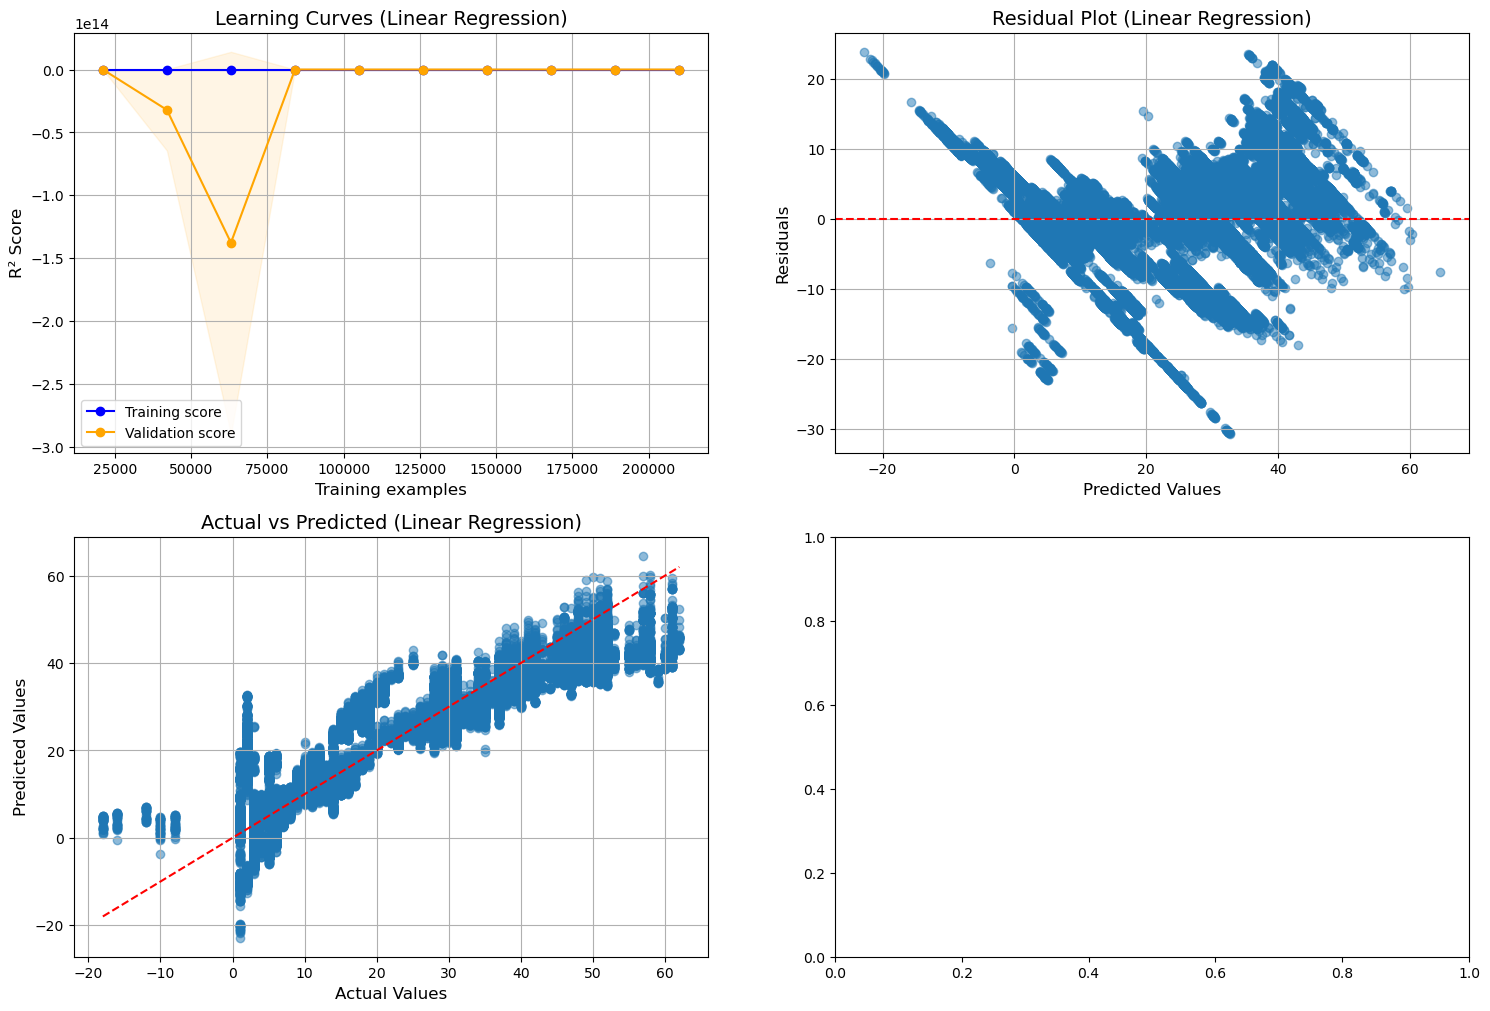

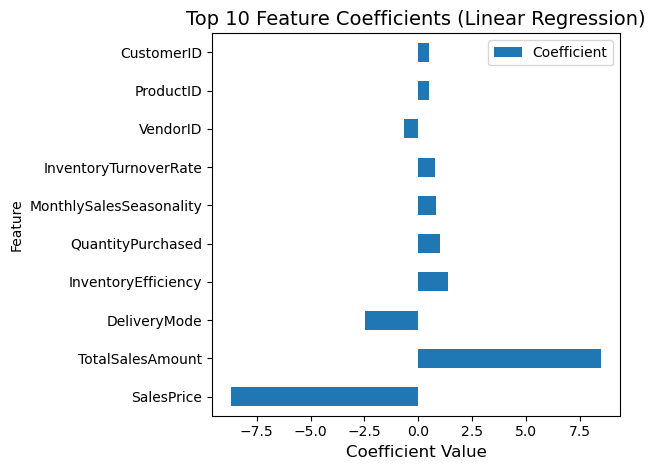

In [19]:
# Linear Regression Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import learning_curve

# Initialize the model
lr_model = LinearRegression()

# Train the model
print("Training Linear Regression Model...")
lr_model.fit(X_train, y_train)

# Make predictions on validation and test sets
y_val_pred_lr = lr_model.predict(X_val)
y_test_pred_lr = lr_model.predict(X_test)

# Calculate metrics
lr_val_r2 = r2_score(y_val, y_val_pred_lr)
lr_test_r2 = r2_score(y_test, y_test_pred_lr)
lr_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_lr))
lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
lr_val_mae = mean_absolute_error(y_val, y_val_pred_lr)
lr_test_mae = mean_absolute_error(y_test, y_test_pred_lr)

# Print results
print("\nLinear Regression Model Results:")
print(f"Validation R² Score: {lr_val_r2:.4f}")
print(f"Test R² Score: {lr_test_r2:.4f}")
print(f"Validation RMSE: {lr_val_rmse:.4f}")
print(f"Test RMSE: {lr_test_rmse:.4f}")
print(f"Validation MAE: {lr_val_mae:.4f}")
print(f"Test MAE: {lr_test_mae:.4f}")

# Feature coefficients
coefficients = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

# Create figure with subplots
plt.figure(figsize=(18, 12))

# Plot 1: Learning curves
plt.subplot(2, 2, 1)
train_sizes, train_scores, val_scores = learning_curve(
    lr_model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="orange")
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="orange", label="Validation score")
plt.title("Learning Curves (Linear Regression)", fontsize=14)
plt.xlabel("Training examples", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.legend(loc="best")
plt.grid(True)

# Plot 2: Residuals
plt.subplot(2, 2, 2)
residuals = y_val - y_val_pred_lr
plt.scatter(y_val_pred_lr, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot (Linear Regression)", fontsize=14)
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.grid(True)

# Plot 3: Actual vs Predicted
plt.subplot(2, 2, 3)
plt.scatter(y_val, y_val_pred_lr, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Actual vs Predicted (Linear Regression)", fontsize=14)
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.grid(True)

# Plot 4: Feature Coefficients
plt.subplot(2, 2, 4)
coefficients.head(10).plot(kind='barh', x='Feature', y='Coefficient')
plt.title("Top 10 Feature Coefficients (Linear Regression)", fontsize=14)
plt.xlabel("Coefficient Value", fontsize=12)
plt.tight_layout()
plt.show()

# Store results for comparison
lr_results = {
    'Model': 'Linear Regression',
    'Val R²': lr_val_r2,
    'Test R²': lr_test_r2,
    'Val RMSE': lr_val_rmse,
    'Test RMSE': lr_test_rmse,
    'Val MAE': lr_val_mae,
    'Test MAE': lr_test_mae
}


## 2️⃣ Random Forest Regressor

### With Less Features (Have to exec code of case of less features in features eng)! 

Training Random Forest Model...

Random Forest Model Results:
Validation R² Score: 0.9797
Test R² Score: 0.9798
Validation RMSE: 2.1495
Test RMSE: 2.1392
Validation MAE: 1.2248
Test MAE: 1.2166


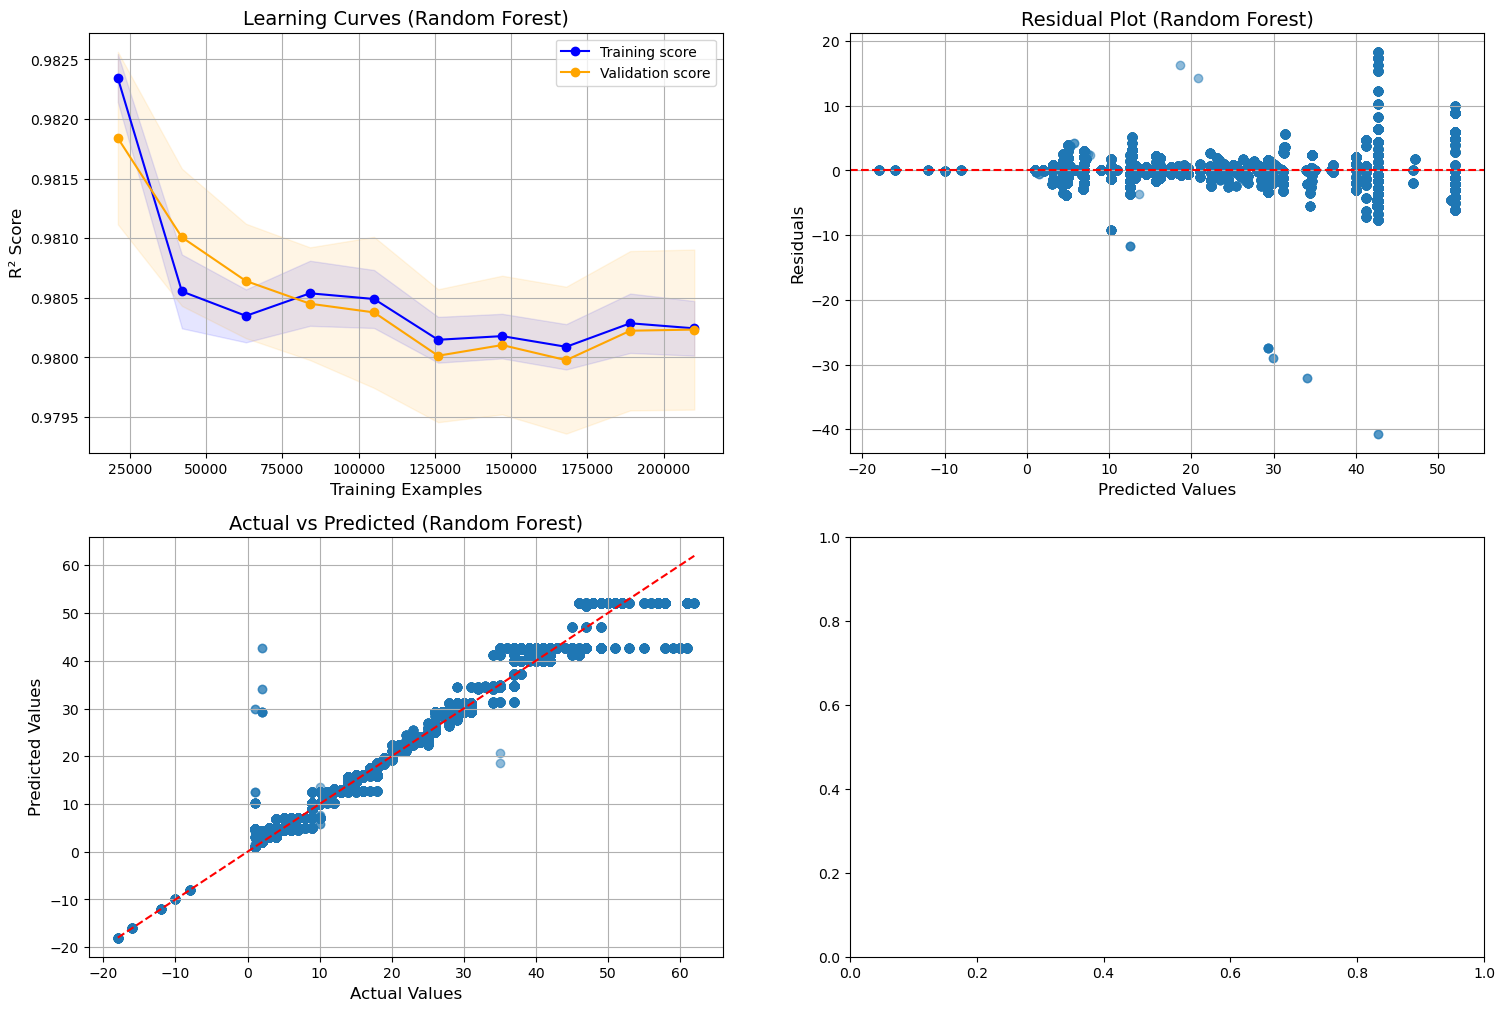

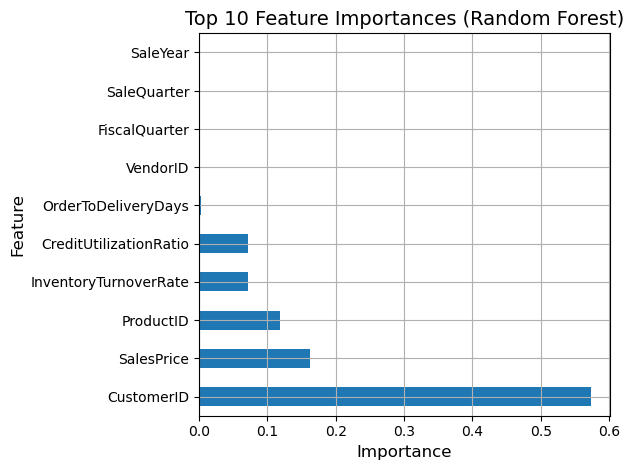

Mean of val 'QuantitySold': 18.2607
Mean of test 'QuantitySold': 18.2662
Std of 'QuantitySold' in Validation set: 15.0689
Std of 'QuantitySold' in Test set:       15.0413


In [45]:
# Random Forest Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import learning_curve

# Initialize the model with hyperparameters
rf_model = RandomForestRegressor(
    n_estimators=70,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Train the model
print("Training Random Forest Model...")
rf_model.fit(X_train, y_train)

# Make predictions on validation and test sets
y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)


# Calculate metrics
rf_val_r2 = r2_score(y_val, y_val_pred_rf)
rf_test_r2 = r2_score(y_test, y_test_pred_rf)
rf_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
rf_val_mae = mean_absolute_error(y_val, y_val_pred_rf)
rf_test_mae = mean_absolute_error(y_test, y_test_pred_rf)


# Print results
print("\nRandom Forest Model Results:")
print(f"Validation R² Score: {rf_val_r2:.4f}")
print(f"Test R² Score: {rf_test_r2:.4f}")
print(f"Validation RMSE: {rf_val_rmse:.4f}")
print(f"Test RMSE: {rf_test_rmse:.4f}")
print(f"Validation MAE: {rf_val_mae:.4f}")
print(f"Test MAE: {rf_test_mae:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Create figure with subplots
plt.figure(figsize=(18, 12))

# Plot 1: Learning curves
plt.subplot(2, 2, 1)
train_sizes, train_scores, val_scores = learning_curve(
    rf_model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="orange")
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="orange", label="Validation score")
plt.title("Learning Curves (Random Forest)", fontsize=14)
plt.xlabel("Training Examples", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.legend(loc="best")
plt.grid(True)

# Plot 2: Residuals
plt.subplot(2, 2, 2)
residuals = y_val - y_val_pred_rf
plt.scatter(y_val_pred_rf, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot (Random Forest)", fontsize=14)
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.grid(True)

# Plot 3: Actual vs Predicted
plt.subplot(2, 2, 3)
plt.scatter(y_val, y_val_pred_rf, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Actual vs Predicted (Random Forest)", fontsize=14)
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.grid(True)

# Plot 4: Feature Importance
plt.subplot(2, 2, 4)
feature_importance.head(10).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title("Top 10 Feature Importances (Random Forest)", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

# Store results for comparison
rf_results = {
    'Model': 'Random Forest',
    'Val R²': rf_val_r2,
    'Test R²': rf_test_r2,
    'Val RMSE': rf_val_rmse,
    'Test RMSE': rf_test_rmse,
    'Val MAE': rf_val_mae,
    'Test MAE': rf_test_mae,
}

# 1) Mean of the target over the entire dataset
mean_target = y_val.mean()
print(f"Mean of val '{target_column}': {mean_target:.4f}")
mean_target = y_test.mean()
print(f"Mean of test '{target_column}': {mean_target:.4f}")

# 2) Standard deviation of the target in validation and test sets
std_val_target  = np.std(y_val, ddof=0)   # population std
std_test_target = np.std(y_test, ddof=0)

print(f"Std of '{target_column}' in Validation set: {std_val_target:.4f}")
print(f"Std of '{target_column}' in Test set:       {std_test_target:.4f}")


### Using All features 

Training Random Forest Model...

Random Forest Model Results:
Validation R² Score: 0.9991
Test R² Score: 0.9990
Validation RMSE: 0.4602
Test RMSE: 0.4808
Validation MAE: 0.1953
Test MAE: 0.1968


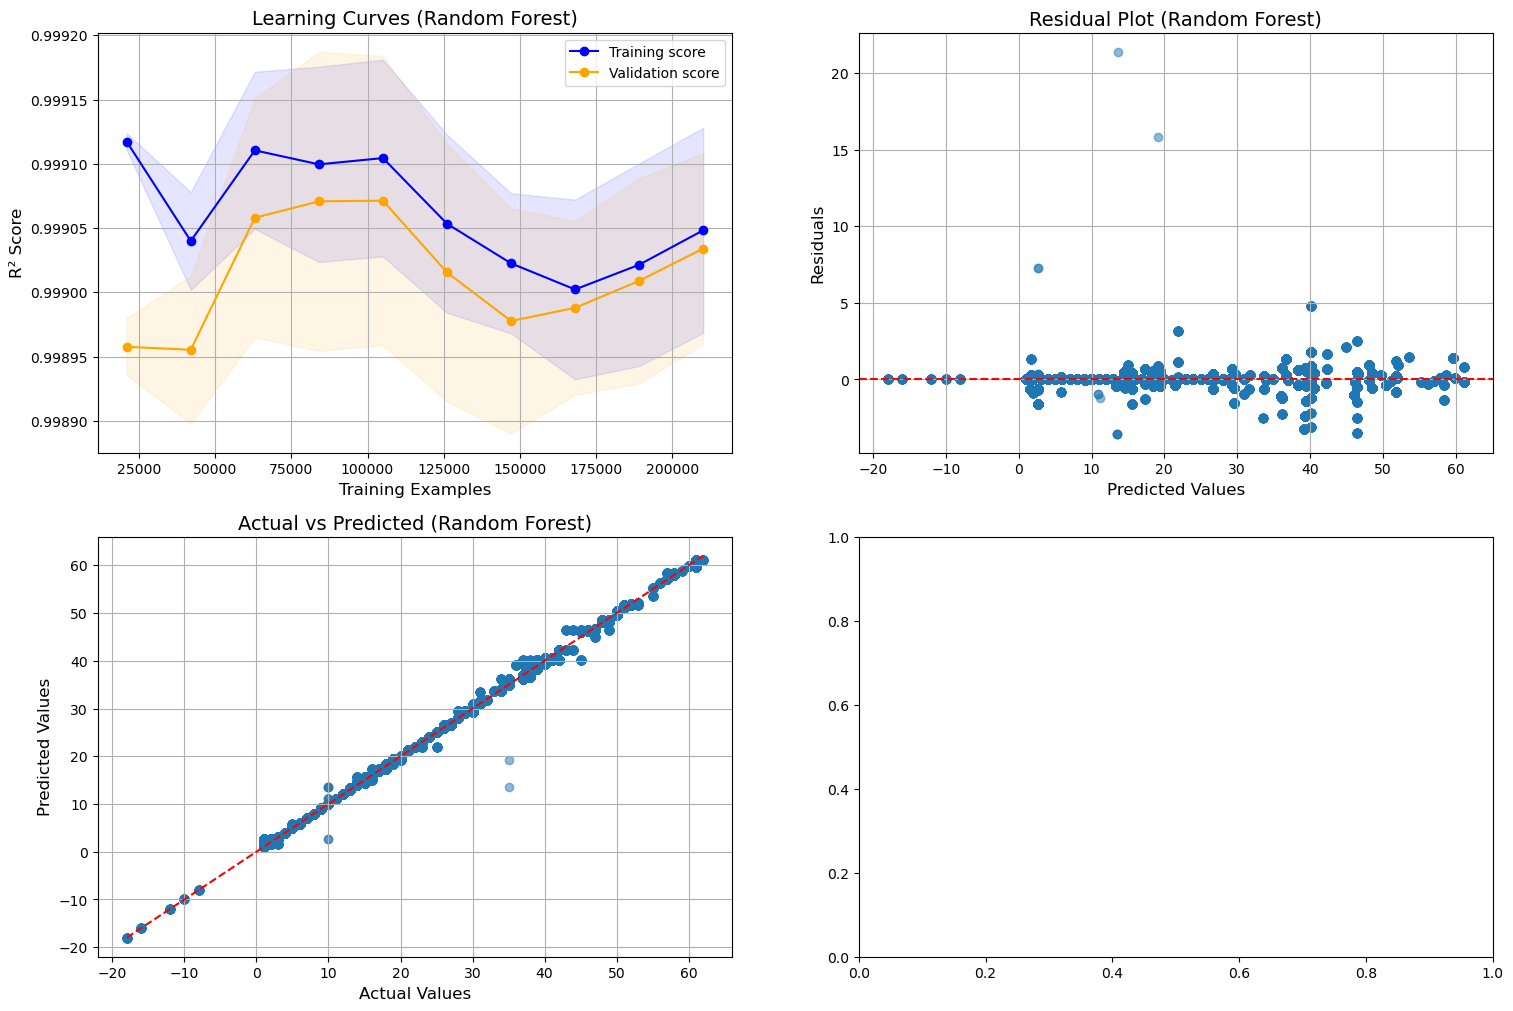

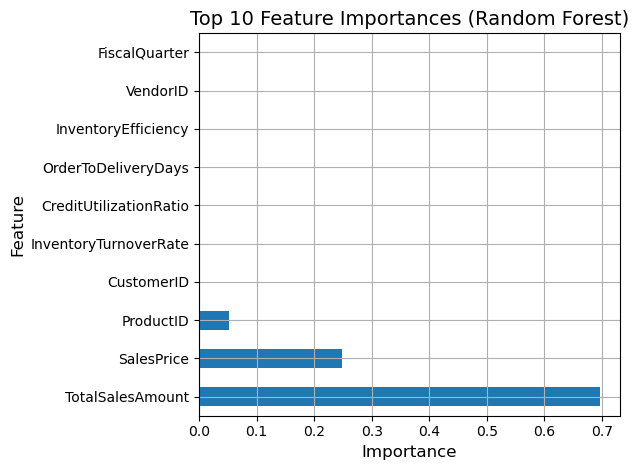

In [20]:
# Random Forest Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import learning_curve

# Initialize the model with hyperparameters
rf_model = RandomForestRegressor(
    n_estimators=70,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Train the model
print("Training Random Forest Model...")
rf_model.fit(X_train, y_train)

# Make predictions on validation and test sets
y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)


# Calculate metrics
rf_val_r2 = r2_score(y_val, y_val_pred_rf)
rf_test_r2 = r2_score(y_test, y_test_pred_rf)
rf_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
rf_val_mae = mean_absolute_error(y_val, y_val_pred_rf)
rf_test_mae = mean_absolute_error(y_test, y_test_pred_rf)


# Print results
print("\nRandom Forest Model Results:")
print(f"Validation R² Score: {rf_val_r2:.4f}")
print(f"Test R² Score: {rf_test_r2:.4f}")
print(f"Validation RMSE: {rf_val_rmse:.4f}")
print(f"Test RMSE: {rf_test_rmse:.4f}")
print(f"Validation MAE: {rf_val_mae:.4f}")
print(f"Test MAE: {rf_test_mae:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Create figure with subplots
plt.figure(figsize=(18, 12))

# Plot 1: Learning curves
plt.subplot(2, 2, 1)
train_sizes, train_scores, val_scores = learning_curve(
    rf_model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="orange")
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="orange", label="Validation score")
plt.title("Learning Curves (Random Forest)", fontsize=14)
plt.xlabel("Training Examples", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.legend(loc="best")
plt.grid(True)

# Plot 2: Residuals
plt.subplot(2, 2, 2)
residuals = y_val - y_val_pred_rf
plt.scatter(y_val_pred_rf, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot (Random Forest)", fontsize=14)
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.grid(True)

# Plot 3: Actual vs Predicted
plt.subplot(2, 2, 3)
plt.scatter(y_val, y_val_pred_rf, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Actual vs Predicted (Random Forest)", fontsize=14)
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.grid(True)

# Plot 4: Feature Importance
plt.subplot(2, 2, 4)
feature_importance.head(10).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title("Top 10 Feature Importances (Random Forest)", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

# Store results for comparison
rf_results = {
    'Model': 'Random Forest',
    'Val R²': rf_val_r2,
    'Test R²': rf_test_r2,
    'Val RMSE': rf_val_rmse,
    'Test RMSE': rf_test_rmse,
    'Val MAE': rf_val_mae,
    'Test MAE': rf_test_mae,
}


## 3️⃣ XGBoost Regressor

Training XGBoost Model...


C:\Users\localadmin\AppData\Local\Temp\2\ipykernel_3236\1994005742.py:93: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 4)  # Corrected subplot position


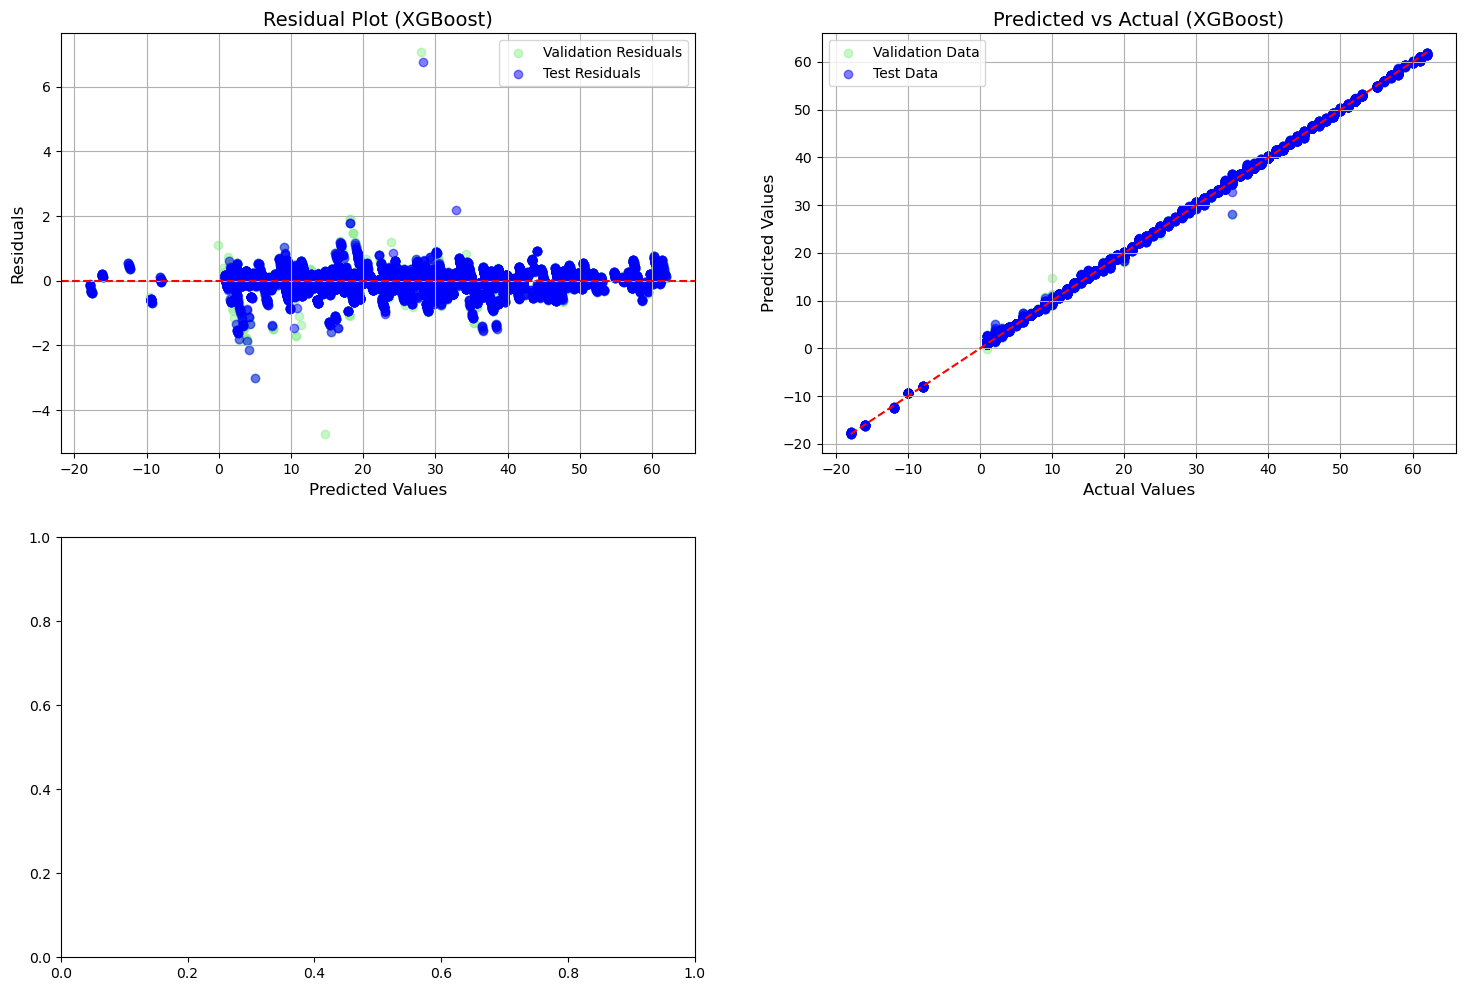

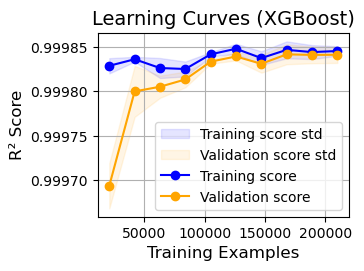


XGBoost Model Results:
Validation R² Score: 0.9998
Test R² Score: 0.9998
Validation RMSE: 0.1888
Test RMSE: 0.1895
Validation MAE: 0.1166
Test MAE: 0.1157


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import learning_curve

# --- Data preparation ---
# Use the train, validation, and test sets from the previous split
X_train, y_train = train_df[feature_columns], train_df[target_column]
X_val, y_val = val_df[feature_columns], val_df[target_column]
X_test, y_test = test_df[feature_columns], test_df[target_column]

# --- Model initialization ---
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# --- Training ---
print("Training XGBoost Model...")
xgb_model.fit(X_train, y_train)

# --- Predictions ---
y_val_pred_xgb = xgb_model.predict(X_val)
y_test_pred_xgb = xgb_model.predict(X_test)

# --- Metrics ---
xgb_val_r2 = r2_score(y_val, y_val_pred_xgb)
xgb_test_r2 = r2_score(y_test, y_test_pred_xgb)
xgb_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_xgb))
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
xgb_val_mae = mean_absolute_error(y_val, y_val_pred_xgb)
xgb_test_mae = mean_absolute_error(y_test, y_test_pred_xgb)

# --- Feature importance ---
feature_importance = pd.DataFrame({
    'Feature': feature_columns,  # Make sure 'feature_columns' is defined
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

# --- Plotting ---
plt.figure(figsize=(18, 12))

# Plot 1: Residuals (with test points in light green)
plt.subplot(2, 2, 1)
residuals = y_val - y_val_pred_xgb
plt.scatter(y_val_pred_xgb, residuals, alpha=0.5, color='lightgreen', label="Validation Residuals")
plt.scatter(y_test_pred_xgb, y_test - y_test_pred_xgb, alpha=0.5, color='blue', label="Test Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot (XGBoost)", fontsize=14)
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.legend(loc='best')
plt.grid(True)

# Plot 2: Predicted vs Actual (Validation vs Predictions)
plt.subplot(2, 2, 2)
plt.scatter(y_val, y_val_pred_xgb, alpha=0.5, color='lightgreen', label="Validation Data")
plt.scatter(y_test, y_test_pred_xgb, alpha=0.5, color='blue', label="Test Data")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--')
plt.title("Predicted vs Actual (XGBoost)", fontsize=14)
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.legend(loc='best')
plt.grid(True)

# Plot 3: Feature Importance
plt.subplot(2, 2, 3)
feature_importance.head(10).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title("Top 10 Feature Importance (XGBoost)", fontsize=14)
plt.xlabel("Importance", fontsize=12)

#Plot 4 : learning curve 
# --- Learning Curve ---
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X_train, y_train, cv=5, scoring='r2', 
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, random_state=42
)

# Calculer les moyennes et écarts types
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# --- Plot 4: Learning Curve ---
plt.subplot(2, 2, 4)  # Corrected subplot position

# Fill between for training and validation scores
plt.fill_between(train_sizes, train_mean - train_std, 
                 train_mean + train_std, alpha=0.1, color="blue", label="Training score std")
plt.fill_between(train_sizes, valid_mean - valid_std,
                 valid_mean + valid_std, alpha=0.1, color="orange", label="Validation score std")

# Plot the training and validation scores
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, valid_mean, 'o-', color="orange", label="Validation score")

# Title and labels
plt.title("Learning Curves (XGBoost)", fontsize=14)
plt.xlabel("Training Examples", fontsize=12)
plt.ylabel("R² Score", fontsize=12)

# Adding grid and legend
plt.legend(loc="best")
plt.grid(True)

##############
# Show all plots
plt.tight_layout()
plt.show()

# --- Print results ---
print("\nXGBoost Model Results:")
print(f"Validation R² Score: {xgb_val_r2:.4f}")
print(f"Test R² Score: {xgb_test_r2:.4f}")
print(f"Validation RMSE: {xgb_val_rmse:.4f}")
print(f"Test RMSE: {xgb_test_rmse:.4f}")
print(f"Validation MAE: {xgb_val_mae:.4f}")
print(f"Test MAE: {xgb_test_mae:.4f}")

# --- Store results for comparison ---
xgb_results = {
    'Model': 'XGBoost',
    'Val R²': xgb_val_r2,
    'Test R²': xgb_test_r2,
    'Val RMSE': xgb_val_rmse,
    'Test RMSE': xgb_test_rmse,
    'Val MAE': xgb_val_mae,
    'Test MAE': xgb_test_mae
}


## Light GBM Model

### Removing some Features

Training LightGBM Model...
Training until validation scores don't improve for 150 rounds
Did not meet early stopping. Best iteration is:
[100]	train's rmse: 1.23037	valid's rmse: 1.23318


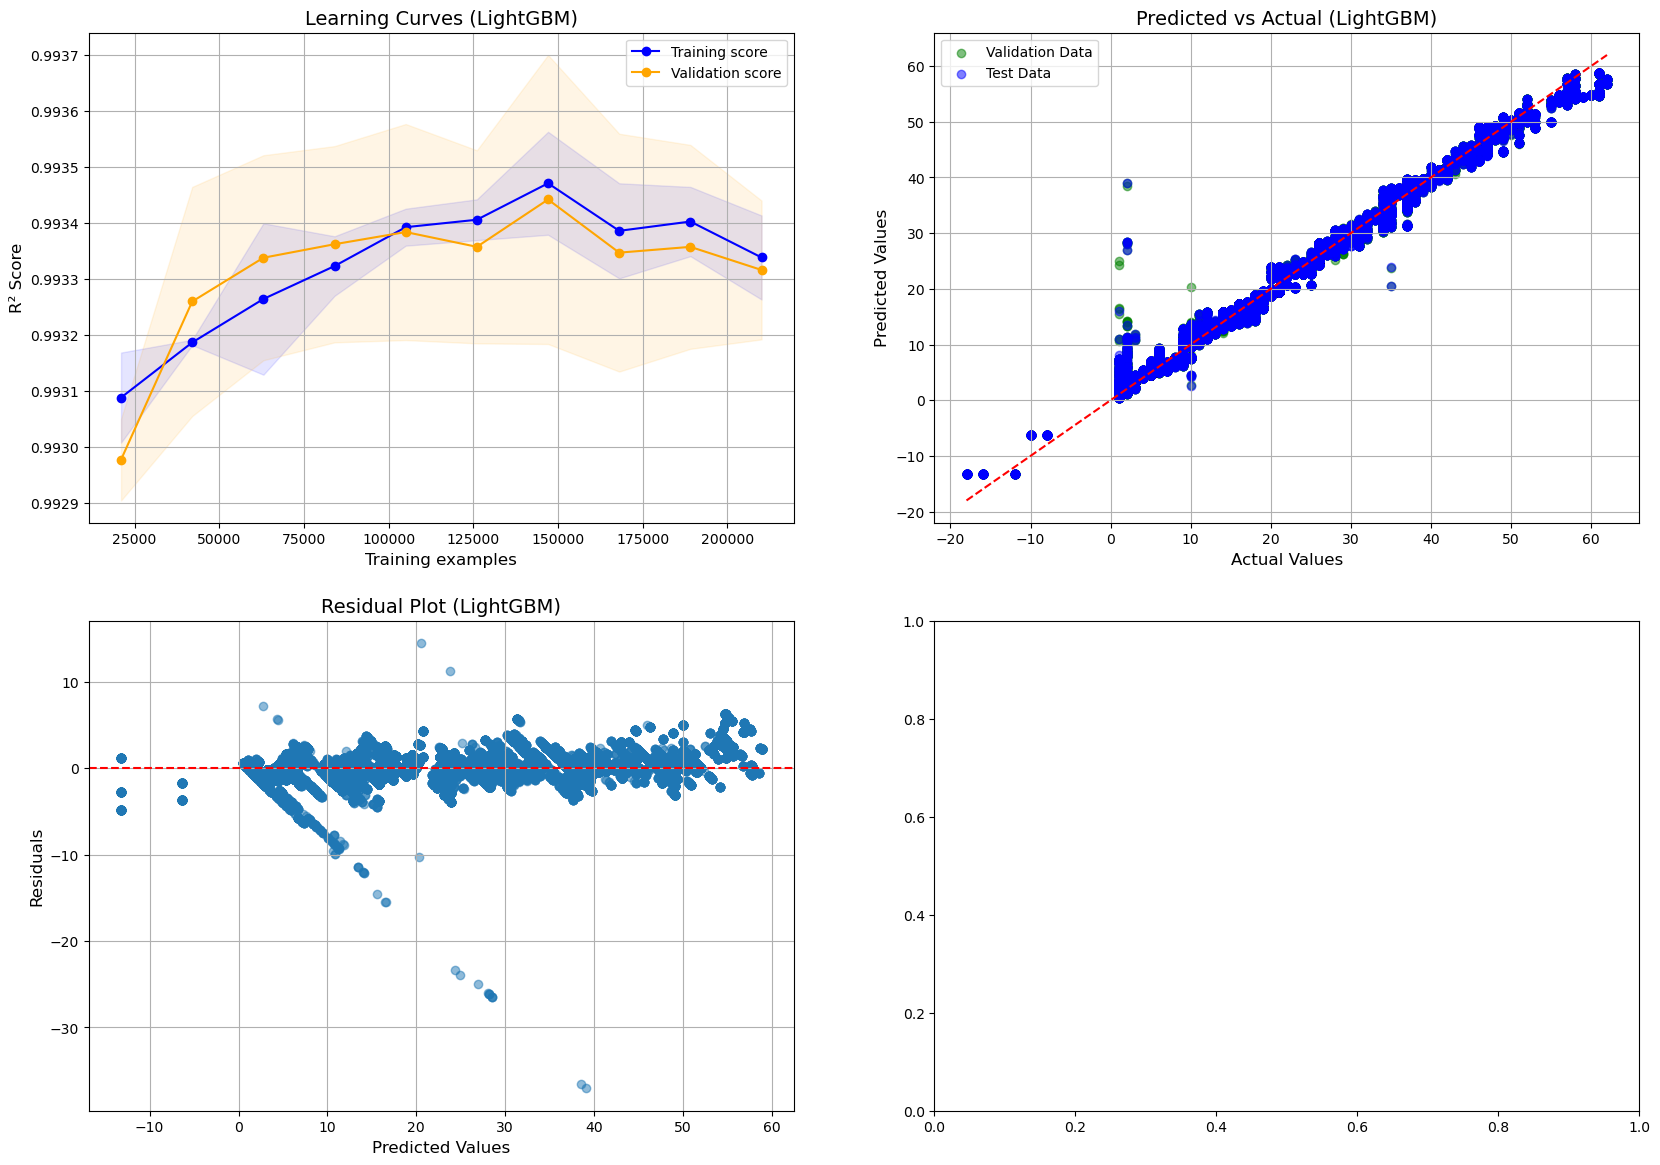

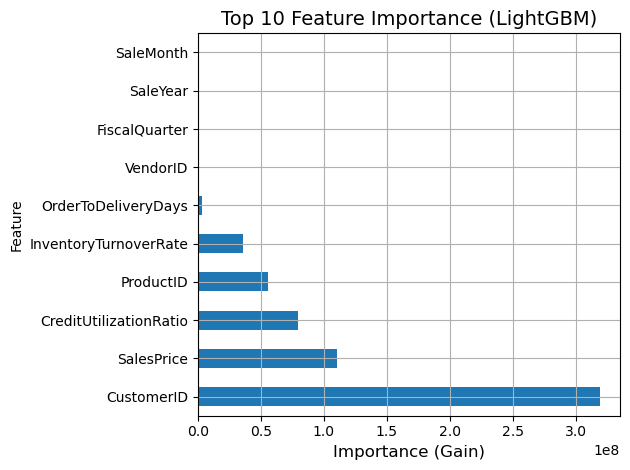


LightGBM Model Results:
Validation R² Score: 0.9933
Validation Adjusted R² Score: 0.9933
Test R² Score: 0.9933
Test Adjusted R² Score: 0.9933
Validation RMSE: 1.2332
Test RMSE: 1.2282
Validation MAE: 0.8412
Test MAE: 0.8364


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import learning_curve

# --- Data Preparation ---
# Create LightGBM datasets for training and validation
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

evals_result = {}

# --- Model Parameters ---
# Set the parameters for LightGBM model
params = {
    'boosting_type': 'gbdt',          # Gradient Boosting Decision Tree method
    'objective': 'regression',        # Set the objective as regression
    'metric': 'rmse',                 # Set the evaluation metric to RMSE (Root Mean Squared Error)
    'num_leaves': 18,                 # Number of leaves in one tree
    'learning_rate': 0.04,            # Step size at each iteration
    'feature_fraction': 0.9,          # Fraction of features to be used for training
    'bagging_fraction': 0.8,          # Fraction of data to be used for training
    'bagging_freq': 5,                # Frequency of bagging
    'verbose': -1                     # Suppress the LightGBM logs
}

# --- Model Training ---
# Train the model using the LightGBM dataset
print("Training LightGBM Model...")
lgb_model = lgb.train(
    params,                          # Model parameters
    lgb_train,                        # Training dataset
    num_boost_round=100,             # Number of boosting rounds (iterations)
    valid_sets=[lgb_train, lgb_val],  # Validation datasets (train and validation)
    valid_names=['train', 'valid'],  # Names of the validation sets
    callbacks=[                      # Early stopping callback to prevent overfitting
        lgb.early_stopping(stopping_rounds=150),
        lgb.record_evaluation(evals_result)
    ]
)

# --- Model Predictions ---
# Predict on the validation and test datasets
y_val_pred_lgb = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
y_test_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

# --- Metrics Calculation ---
# Calculate R², RMSE, and MAE for the validation and test predictions
lgb_val_r2 = r2_score(y_val, y_val_pred_lgb)
lgb_test_r2 = r2_score(y_test, y_test_pred_lgb)

# Calculate Adjusted R²
n_val = X_val.shape[0]  # number of validation samples
p_val = X_val.shape[1]  # number of features
lgb_val_r2_adj = 1 - (1 - lgb_val_r2) * (n_val - 1) / (n_val - p_val - 1)

n_test = X_test.shape[0]  # number of test samples
p_test = X_test.shape[1]  # same number of features
lgb_test_r2_adj = 1 - (1 - lgb_test_r2) * (n_test - 1) / (n_test - p_test - 1)


lgb_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_lgb))
lgb_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lgb))
lgb_val_mae = mean_absolute_error(y_val, y_val_pred_lgb)
lgb_test_mae = mean_absolute_error(y_test, y_test_pred_lgb)

# --- Feature Importance ---
# Get the feature importance based on the 'gain' metric
feature_importance = pd.DataFrame({
    'Feature': feature_columns,  # Ensure 'feature_columns' is defined
    'Importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('Importance', ascending=False)

# --- Visualization ---
plt.figure(figsize=(20, 14))

# Plot 1: Learning Curve (Training vs Validation scores over training size)
plt.subplot(2, 2, 1)
train_sizes, train_scores, val_scores = learning_curve(
    lgb.LGBMRegressor(**params), X_train, y_train, cv=5, scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve with confidence intervals
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="orange")
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="orange", label="Validation score")
plt.title("Learning Curves (LightGBM)", fontsize=14)
plt.xlabel("Training examples", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.legend(loc="best")
plt.grid(True)

# Plot 2: Actual vs Predicted (Validation and Test datasets)
plt.subplot(2, 2, 2)
plt.scatter(y_val, y_val_pred_lgb, alpha=0.5, color='green', label="Validation Data")
plt.scatter(y_test, y_test_pred_lgb, alpha=0.5, color='blue', label="Test Data")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
plt.title("Predicted vs Actual (LightGBM)", fontsize=14)
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.legend()
plt.grid(True)

# Plot 3: Residual Plot (Validation data)
plt.subplot(2, 2, 3)
residuals = y_val - y_val_pred_lgb
plt.scatter(y_val_pred_lgb, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot (LightGBM)", fontsize=14)
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.grid(True)

# Plot 4: Top 10 Feature Importance (Bar chart)
plt.subplot(2, 2, 4)
feature_importance.head(10).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title("Top 10 Feature Importance (LightGBM)", fontsize=14)
plt.xlabel("Importance (Gain)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Results ---
# Print model evaluation results
print("\nLightGBM Model Results:")
print(f"Validation R² Score: {lgb_val_r2:.4f}")
print(f"Validation Adjusted R² Score: {lgb_val_r2_adj:.4f}")
print(f"Test R² Score: {lgb_test_r2:.4f}")
print(f"Test Adjusted R² Score: {lgb_test_r2_adj:.4f}")
print(f"Validation RMSE: {lgb_val_rmse:.4f}")
print(f"Test RMSE: {lgb_test_rmse:.4f}")
print(f"Validation MAE: {lgb_val_mae:.4f}")
print(f"Test MAE: {lgb_test_mae:.4f}")


# --- Store Results for Comparison ---
lgb_results = {
    'Model': 'LightGBM',
    'Val R²': lgb_val_r2,
    'Test R²': lgb_test_r2,
    'Val RMSE': lgb_val_rmse,
    'Test RMSE': lgb_test_rmse,
    'Val MAE': lgb_val_mae,
    'Test MAE': lgb_test_mae
}


In [ ]:
mean_value = y_test.mean()
print(f"Mean of {target_column}: {mean_value}")


Mean of QuantitySold: 18.266206418594734


<Figure size 1000x600 with 0 Axes>

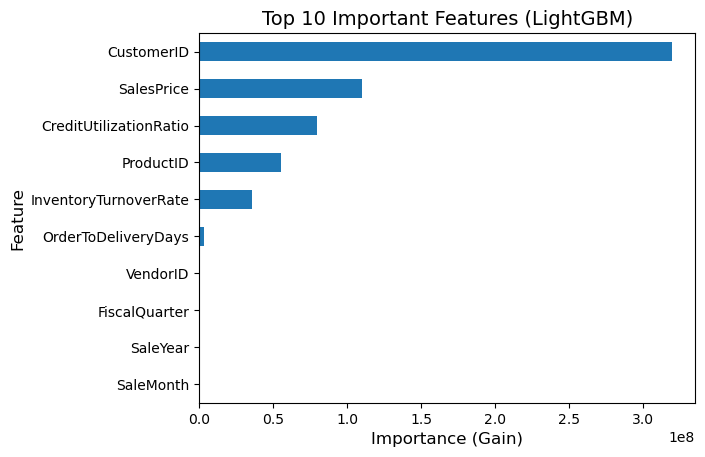

In [49]:
def plot_feature_importance(model, feature_columns, num_top_features=10):
    # Get feature importance scores from the model
    importance = model.feature_importance(importance_type='gain')
    
    # Create a DataFrame to hold feature names and their importance scores
    feature_importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': importance
    }).sort_values('Importance', ascending=False)

    # Plot the top 'num_top_features' important features
    plt.figure(figsize=(10, 6))
    feature_importance_df.head(num_top_features).plot(kind='barh', x='Feature', y='Importance', legend=False)
    plt.title(f"Top {num_top_features} Important Features (LightGBM)", fontsize=14)
    plt.xlabel("Importance (Gain)", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.gca().invert_yaxis()
    plt.show()

# Call the function to visualize and print feature importance
plot_feature_importance(lgb_model, feature_columns)


### With all features

Training LightGBM Model...
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	train's rmse: 0.556455	valid's rmse: 0.558353


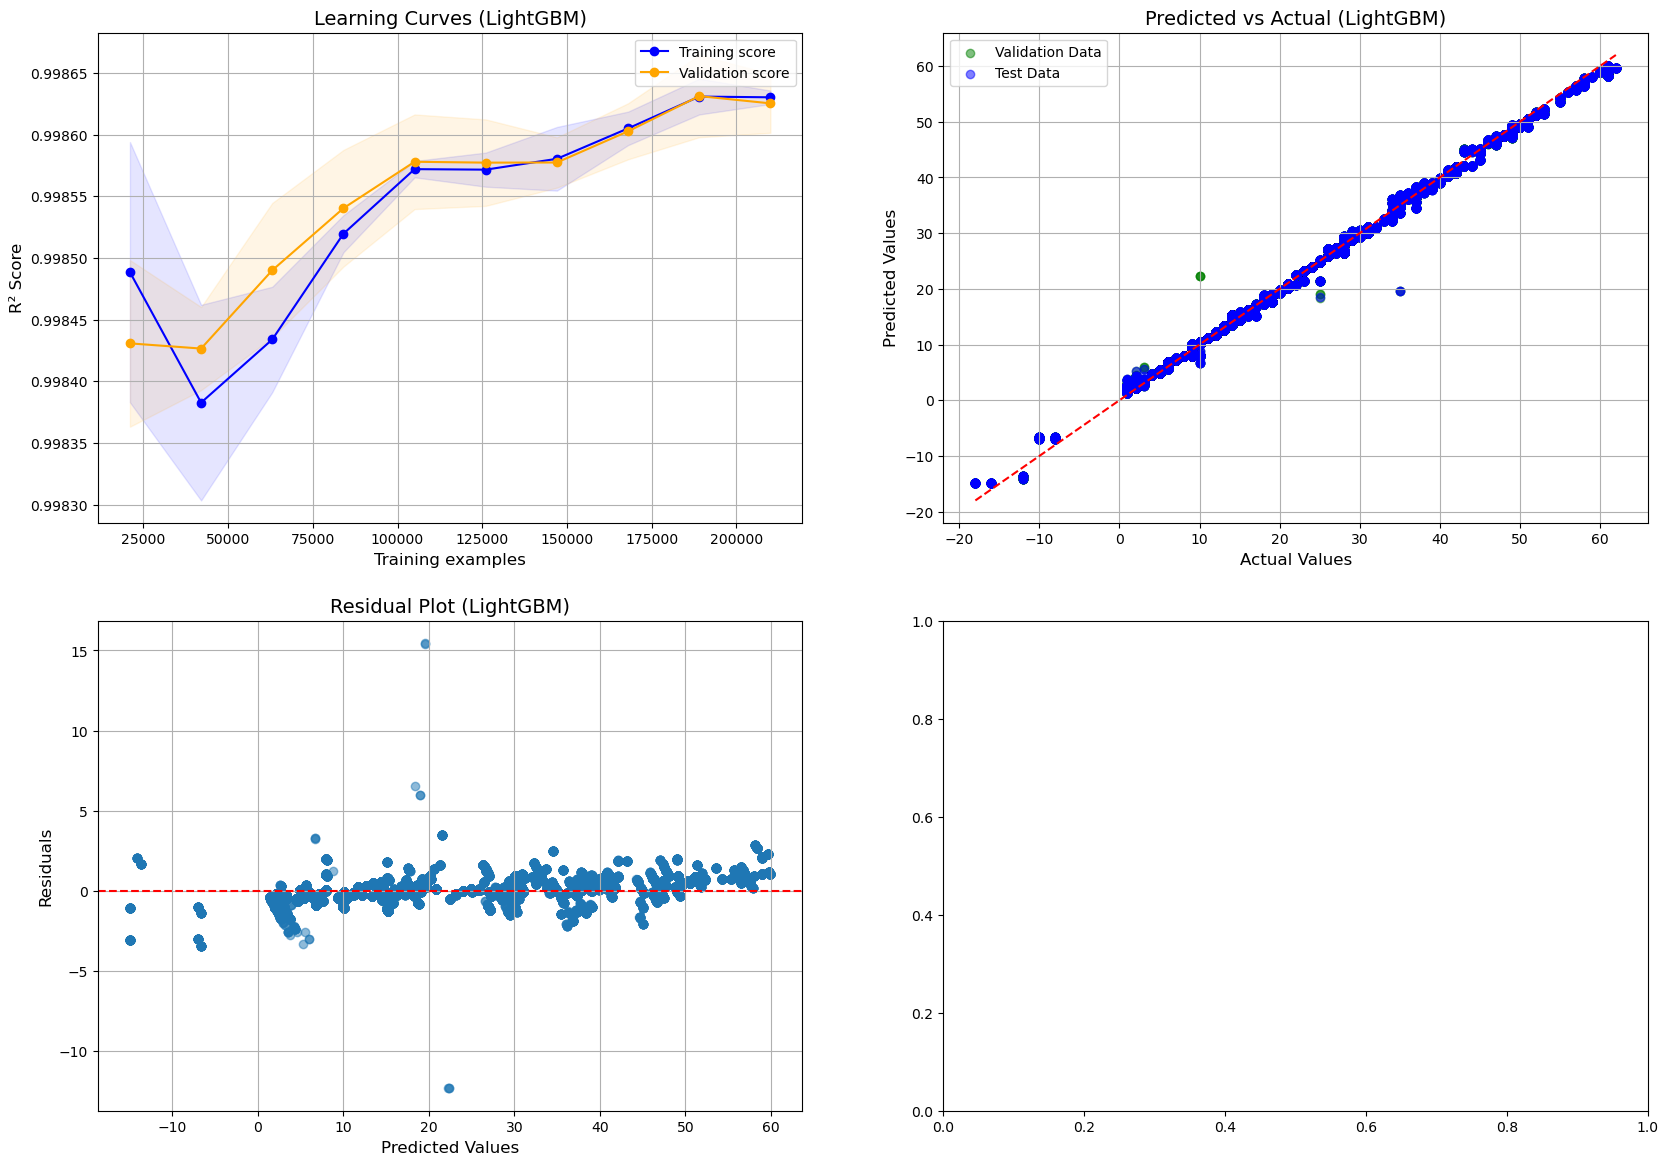

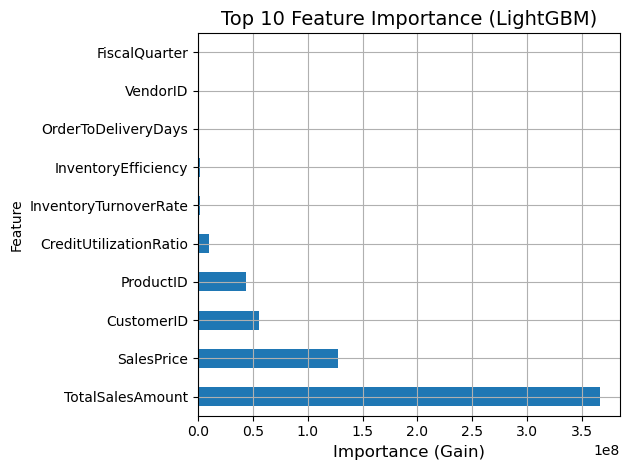


LightGBM Model Results:
Validation R² Score: 0.9986
Validation Adjusted R² Score: 0.9986
Test R² Score: 0.9986
Test Adjusted R² Score: 0.9986
Validation RMSE: 0.5584
Test RMSE: 0.5578
Validation MAE: 0.3975
Test MAE: 0.3965


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import learning_curve

# --- Data Preparation ---
# Create LightGBM datasets for training and validation
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

evals_result = {}

# --- Model Parameters ---
# Set the parameters for LightGBM model
params = {
    'boosting_type': 'gbdt',          # Gradient Boosting Decision Tree method
    'objective': 'regression',        # Set the objective as regression
    'metric': 'rmse',                 # Set the evaluation metric to RMSE (Root Mean Squared Error)
    'num_leaves': 18,                 # Number of leaves in one tree
    'learning_rate': 0.04,            # Step size at each iteration
    'feature_fraction': 0.9,          # Fraction of features to be used for training
    'bagging_fraction': 0.8,          # Fraction of data to be used for training
    'bagging_freq': 5,                # Frequency of bagging
    'verbose': -1                     # Suppress the LightGBM logs
}

# --- Model Training ---
# Train the model using the LightGBM dataset
print("Training LightGBM Model...")
lgb_model = lgb.train(
    params,                          # Model parameters
    lgb_train,                        # Training dataset
    num_boost_round=100,             # Number of boosting rounds (iterations)
    valid_sets=[lgb_train, lgb_val],  # Validation datasets (train and validation)
    valid_names=['train', 'valid'],  # Names of the validation sets
    callbacks=[                      # Early stopping callback to prevent overfitting
        lgb.early_stopping(stopping_rounds=100),
        lgb.record_evaluation(evals_result)
    ]
)

# --- Model Predictions ---
# Predict on the validation and test datasets
y_train_pred_lgb = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration)
y_val_pred_lgb = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
y_test_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

# --- Metrics Calculation ---
# Calculate R², RMSE, and MAE for the validation and test predictions
lgb_val_r2 = r2_score(y_val, y_val_pred_lgb)
lgb_test_r2 = r2_score(y_test, y_test_pred_lgb)

# Calculate Adjusted R²
n_val = X_val.shape[0]  # number of validation samples
p_val = X_val.shape[1]  # number of features
lgb_val_r2_adj = 1 - (1 - lgb_val_r2) * (n_val - 1) / (n_val - p_val - 1)

n_test = X_test.shape[0]  # number of test samples
p_test = X_test.shape[1]  # same number of features
lgb_test_r2_adj = 1 - (1 - lgb_test_r2) * (n_test - 1) / (n_test - p_test - 1)


lgb_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_lgb))
lgb_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lgb))
lgb_val_mae = mean_absolute_error(y_val, y_val_pred_lgb)
lgb_test_mae = mean_absolute_error(y_test, y_test_pred_lgb)

# --- Feature Importance ---
# Get the feature importance based on the 'gain' metric
feature_importance = pd.DataFrame({
    'Feature': feature_columns,  # Ensure 'feature_columns' is defined
    'Importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('Importance', ascending=False)

# --- Visualization ---
plt.figure(figsize=(20, 14))

# Plot 1: Learning Curve (Training vs Validation scores over training size)
plt.subplot(2, 2, 1)
train_sizes, train_scores, val_scores = learning_curve(
    lgb.LGBMRegressor(**params), X_train, y_train, cv=5, scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve with confidence intervals
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="orange")
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="orange", label="Validation score")
plt.title("Learning Curves (LightGBM)", fontsize=14)
plt.xlabel("Training examples", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.legend(loc="best")
plt.grid(True)

# Plot 2: Actual vs Predicted (Validation and Test datasets)
plt.subplot(2, 2, 2)
plt.scatter(y_val, y_val_pred_lgb, alpha=0.5, color='green', label="Validation Data")
plt.scatter(y_test, y_test_pred_lgb, alpha=0.5, color='blue', label="Test Data")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
plt.title("Predicted vs Actual (LightGBM)", fontsize=14)
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.legend()
plt.grid(True)

# Plot 3: Residual Plot (Validation data)
plt.subplot(2, 2, 3)
residuals = y_val - y_val_pred_lgb
plt.scatter(y_val_pred_lgb, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot (LightGBM)", fontsize=14)
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.grid(True)

# Plot 4: Top 10 Feature Importance (Bar chart)
plt.subplot(2, 2, 4)
feature_importance.head(10).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title("Top 10 Feature Importance (LightGBM)", fontsize=14)
plt.xlabel("Importance (Gain)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Results ---
# Print model evaluation results
print("\nLightGBM Model Results:")
print(f"Validation R² Score: {lgb_val_r2:.4f}")
print(f"Validation Adjusted R² Score: {lgb_val_r2_adj:.4f}")
print(f"Test R² Score: {lgb_test_r2:.4f}")
print(f"Test Adjusted R² Score: {lgb_test_r2_adj:.4f}")
print(f"Validation RMSE: {lgb_val_rmse:.4f}")
print(f"Test RMSE: {lgb_test_rmse:.4f}")
print(f"Validation MAE: {lgb_val_mae:.4f}")
print(f"Test MAE: {lgb_test_mae:.4f}")


# --- Store Results for Comparison ---
lgb_results = {
    'Model': 'LightGBM',
    'Val R²': lgb_val_r2,
    'Test R²': lgb_test_r2,
    'Val RMSE': lgb_val_rmse,
    'Test RMSE': lgb_test_rmse,
    'Val MAE': lgb_val_mae,
    'Test MAE': lgb_test_mae
}


# Comparison between models

Model Performance Comparison:
                   Val R²  Test R²  Val RMSE  Test RMSE  Val MAE  Test MAE
Model                                                                     
Linear Regression  0.8390   0.8402    6.0463     6.0132   4.4926    4.4609
Random Forest      0.9991   0.9990    0.4602     0.4808   0.1953    0.1968
XGBoost            0.9998   0.9998    0.1888     0.1895   0.1166    0.1157
LightGBM           0.9987   0.9987    0.5531     0.5517   0.3946    0.3934


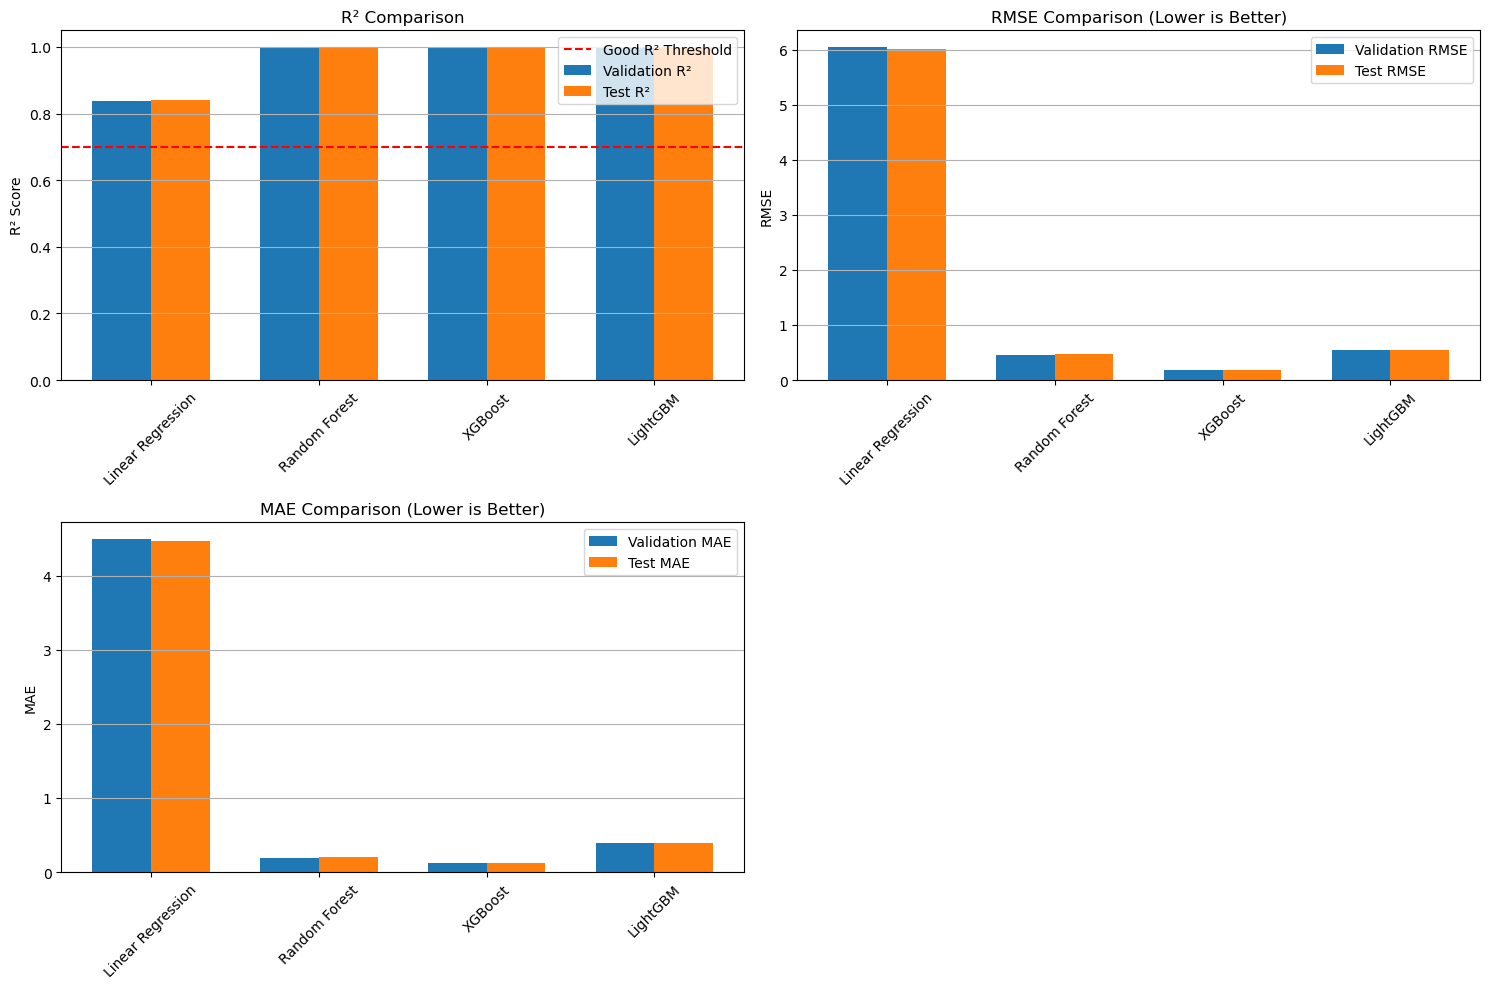


Model Recommendation:
Based on Test R² score, the best performing model is: XGBoost

Detailed Analysis of Best Model:
XGBoost Strengths:
- Often achieves higher accuracy than Random Forest
- Handles regularization to prevent overfitting
- Efficient implementation for large datasets
- Good at capturing non-linear patterns

XGBoost Weaknesses:
- More parameters to tune compared to Random Forest
- Can overfit if not properly configured
- Less interpretable than linear models

Suggestions for Model Improvement:
1. Hyperparameter Tuning: Perform grid search or random search for optimal parameters
2. Feature Engineering: Create additional features that might capture seasonal patterns
3. Ensemble Methods: Combine predictions from multiple models for better accuracy
4. Data Augmentation: Generate synthetic data if the dataset is small
5. Regularization: Apply appropriate regularization techniques to prevent overfitting


In [ ]:
# Model Comparison
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create dataframe for comparison (in order)
results_df = pd.DataFrame([lr_results, rf_results, xgb_results, lgb_results])

# Print tabular comparison
print("Model Performance Comparison:")
print(results_df.set_index('Model').round(4))

# Create visual comparison
plt.figure(figsize=(15, 10))

models = results_df['Model']
x = np.arange(len(models))
width = 0.35

# R² comparison
plt.subplot(2, 2, 1)
plt.bar(x - width/2, results_df['Val R²'], width, label='Validation R²')
plt.bar(x + width/2, results_df['Test R²'], width, label='Test R²')
plt.axhline(y=0.7, color='r', linestyle='--', label='Good R² Threshold')
plt.ylabel('R² Score')
plt.title('R² Comparison')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.grid(True, axis='y')

# RMSE comparison
plt.subplot(2, 2, 2)
plt.bar(x - width/2, results_df['Val RMSE'], width, label='Validation RMSE')
plt.bar(x + width/2, results_df['Test RMSE'], width, label='Test RMSE')
plt.ylabel('RMSE')
plt.title('RMSE Comparison (Lower is Better)')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.grid(True, axis='y')

# MAE comparison
plt.subplot(2, 2, 3)
plt.bar(x - width/2, results_df['Val MAE'], width, label='Validation MAE')
plt.bar(x + width/2, results_df['Test MAE'], width, label='Test MAE')
plt.ylabel('MAE')
plt.title('MAE Comparison (Lower is Better)')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

# Final recommendation
print("\nModel Recommendation:")
best_model_index = results_df['Test R²'].idxmax()
best_model = results_df.loc[best_model_index, 'Model']
print(f"Based on Test R² score, the best performing model is: {best_model}")

# Detailed analysis of best model's strengths and weaknesses
print("\nDetailed Analysis of Best Model:")
if best_model == 'Random Forest':
    print("Random Forest Strengths:")
    print("- Robust to outliers and non-linear data")
    print("- Handles missing values well")
    print("- Provides feature importance")
    print("- Less prone to overfitting compared to decision trees")
    print("\nRandom Forest Weaknesses:")
    print("- Can be computationally expensive for large datasets")
    print("- Less interpretable than linear models")
elif best_model == 'XGBoost':
    print("XGBoost Strengths:")
    print("- Often achieves higher accuracy than Random Forest")
    print("- Handles regularization to prevent overfitting")
    print("- Efficient implementation for large datasets")
    print("- Good at capturing non-linear patterns")
    print("\nXGBoost Weaknesses:")
    print("- More parameters to tune compared to Random Forest")
    print("- Can overfit if not properly configured")
    print("- Less interpretable than linear models")
elif best_model == 'LightGBM':
    print("LightGBM Strengths:")
    print("- Fast training speed and high efficiency")
    print("- Handles large datasets well")
    print("- Good at capturing non-linear patterns")
    print("- Provides feature importance")
    print("\nLightGBM Weaknesses:")
    print("- Sensitive to overfitting if not tuned properly")
    print("- Less interpretable than linear models")
elif best_model == 'Linear Regression':
    print("Linear Regression Strengths:")
    print("- Simple and interpretable")
    print("- Fast to train")
    print("- Works well with linearly separable data")
    print("\nLinear Regression Weaknesses:")
    print("- Assumes linear relationship between features and target")
    print("- Sensitive to outliers")
    print("- May not capture complex patterns in data")

# Suggestions for model improvement
print("\nSuggestions for Model Improvement:")
print("1. Hyperparameter Tuning: Perform grid search or random search for optimal parameters")
print("2. Feature Engineering: Create additional features that might capture seasonal patterns")
print("3. Ensemble Methods: Combine predictions from multiple models for better accuracy")
print("4. Data Augmentation: Generate synthetic data if the dataset is small")
print("5. Regularization: Apply appropriate regularization techniques to prevent overfitting")


# Save model LGBM for use  

In [ ]:
import joblib

# --- Enregistrer le modèle LightGBM ---
model_filename = "QS_lightgbm_model_NotTuned.pkl"
joblib.dump(lgb_model, model_filename)
print(f"Modèle enregistré sous : {model_filename}")


Modèle enregistré sous : QS_lightgbm_model.pkl


# Test Model on External data test : dfFinalTest ( Before Tuning Params)

📌 Final Test Data Evaluation:
✅ RMSE: 0.5739
✅ R² Score: 0.9985


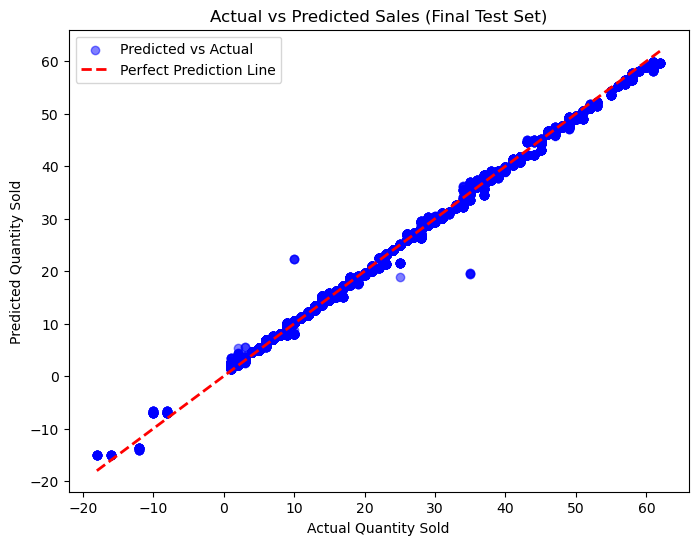

In [20]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Make predictions
y_final_pred = lgb_model.predict(X_final_test)

# If dfFinalTest has actual target values, evaluate performance
if target_column in dfFinalTest:
    y_final_actual = dfFinalTest[target_column]
    
    # Compute evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_final_actual, y_final_pred))
    r2 = r2_score(y_final_actual, y_final_pred)

    print(f"📌 Final Test Data Evaluation:")
    print(f"✅ RMSE: {rmse:.4f}")
    print(f"✅ R² Score: {r2:.4f}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_final_actual, y_final_pred, alpha=0.5, color="blue", label="Predicted vs Actual")
    plt.plot([min(y_final_actual), max(y_final_actual)], [min(y_final_actual), max(y_final_actual)], 
             color="red", linestyle="dashed", linewidth=2, label="Perfect Prediction Line")
    plt.xlabel("Actual Quantity Sold")
    plt.ylabel("Predicted Quantity Sold")
    plt.title("Actual vs Predicted Sales (Final Test Set)")
    plt.legend()
    plt.show()
    
else:
    print("⚠️ No actual values found in dfFinalTest. Predictions only:")
    print(y_final_pred[:10])  # Display first 10 predictions


## Save Data for Power BI 

### Meth 1

In [ ]:
# --- 1. Build one results DataFrame per split ---  
def build_results_df(X, y_true, y_pred, split_name):
    """
    X:      feature-DataFrame for this split (must include 'row_id')
    y_true: actual target values (Series or array)
    y_pred: predicted values (array)
    split_name: one of 'train', 'val', 'test', 'final'
    """
    df = pd.DataFrame({
        'row_id':     X['row_id'].values,
        'Actual':     y_true if isinstance(y_true, (list, np.ndarray)) else y_true.values,
        'Predicted':  y_pred,
        'Split':      split_name
    })
    return df

# Create for each split (replace y_*_pred and y_* with your actual variables)
df_train_res  = build_results_df(X_train,      y_train,      y_train_pred_lgb,  'train')
df_val_res    = build_results_df(X_val,        y_val,        y_val_pred_lgb,    'val')
df_test_res   = build_results_df(X_test,       y_test,       y_test_pred_lgb,   'test')
df_final_res  = build_results_df(dfFinalTest,  y_final_test, y_final_pred,  'final')

# --- 2. Concatenate all splits into one DataFrame ---
df_all_res = pd.concat(
    [df_train_res, df_val_res, df_test_res, df_final_res],
    ignore_index=True
)

# --- 3. Merge with the original raw DataFrame (dfRowId) on 'row_id' ---
# dfRowId should contain row_id + all raw/original columns
df_merged = df_all_res.merge(dfRowId, on='row_id', how='left')

# --- 4. Save to CSV ---
output_path = 'all_splits_with_predictions.csv'
df_merged.to_csv(output_path, index=False)
print(f"✅ Saved merged results to {output_path}")


### Meth 2

In [ ]:
# ✅ Assumes df_unencodedColumns is your original dataframe (before encoding)
# It must include 'CustomerID' and 'ProductID' and be indexed properly (e.g., same as X)

# --- Create validation export df (2015–2019) ---
df_val_export = X_val.copy()
df_val_export["Actual_Sales"] = y_val.values
df_val_export["Predicted_Sales"] = y_val_pred_lgb
df_val_export["Dataset"] = "2015-2019"
df_val_export["CustomerID"] = df_unencodedColumns.loc[X_val.index, "CustomerID"].values
df_val_export["ProductID"] = df_unencodedColumns.loc[X_val.index, "ProductID"].values

# --- Create test export df (2020) ---
df_test_export = X_test.copy()
df_test_export["Actual_Sales"] = y_test.values
df_test_export["Predicted_Sales"] = y_test_pred_lgb
df_test_export["Dataset"] = "2020"
df_test_export["CustomerID"] = df_unencodedColumns.loc[X_test.index, "CustomerID"].values
df_test_export["ProductID"] = df_unencodedColumns.loc[X_test.index, "ProductID"].values

# --- Combine both ---
df_combined_export = pd.concat([df_val_export, df_test_export], ignore_index=True)

# --- Optional: reorder columns if needed ---
cols_order = ["CustomerID", "ProductID", "Actual_Sales", "Predicted_Sales", "Dataset"] + \
             [col for col in df_combined_export.columns if col not in ["CustomerID", "ProductID", "Actual_Sales", "Predicted_Sales", "Dataset"]]
df_combined_export = df_combined_export[cols_order]

# --- Save to CSV ---
df_combined_export.to_csv("sales_prediction_results.csv", index=False)

print("✅ File 'sales_prediction_results.csv' saved successfully.")


✅ File 'sales_prediction_results.csv' saved successfully.


#  Hyperparameter Tuning with Optuna of RF

1️⃣ GridSearchCV (Exhaustive Search)

📌 What it does

Brute-force search over a predefined set of hyperparameter values.

It trains and evaluates the model on every possible combination of parameters.

Uses cross-validation to determine the best set.

📌 Pros

✅ Simple to understand and implement.

✅ Guarantees finding the best combination (if within the search space).

📌 Cons

❌ Computationally expensive for large search spaces.

❌ Doesn't adapt based on previous results (tries all combinations blindly).

2️⃣ Optuna (Smart Search)

📌 What it does

Optimized search using Bayesian Optimization.

Learns from previous results to focus on promising regions.

Uses pruning to stop bad models early, saving time.

📌 Pros

✅ Much faster than GridSearchCV.

✅ Finds better hyperparameters in fewer trials.

✅ Can handle large search spaces efficiently.


📌 Cons

❌ Doesn't guarantee the absolute best solution (but finds close enough).

❌ Requires some tuning of the search algorithm.


In [29]:
import optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb

def objective(trial):
    # Hyperparameter search space
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.4, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    # Train the model with LightGBM
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    # Predict on the validation set
    y_pred = model.predict(X_val)

    # Calculate metrics
    mae = mean_absolute_error(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    r2 = r2_score(y_val, y_pred)

    # Custom loss function
    # Penalize R² > 0.99
    penalty = 10 * (r2 - 0.99) if r2 > 0.99 else 0

    # Composite metric: Minimize MAE and RMSE while keeping R² < 0.99
    loss = mae + rmse + penalty

    return loss

# Run the Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best Hyperparameters:", study.best_trial.params)
print("Best Loss (Composite of MAE, RMSE, and R² constraint):", study.best_trial.value)


[I 2025-05-09 13:10:24,792] A new study created in memory with name: no-name-d64f52e1-e2ff-4c40-a761-247011239f42
[I 2025-05-09 13:10:52,632] Trial 0 finished with value: 0.13627863318724145 and parameters: {'num_leaves': 44, 'max_depth': 18, 'learning_rate': 0.13146753749774298, 'n_estimators': 990, 'min_child_samples': 34}. Best is trial 0 with value: 0.13627863318724145.
[I 2025-05-09 13:11:02,151] Trial 1 finished with value: 0.16697732742122348 and parameters: {'num_leaves': 80, 'max_depth': 18, 'learning_rate': 0.2010228125692776, 'n_estimators': 149, 'min_child_samples': 57}. Best is trial 0 with value: 0.13627863318724145.
[I 2025-05-09 13:11:43,147] Trial 2 finished with value: 0.1599306278063956 and parameters: {'num_leaves': 134, 'max_depth': 19, 'learning_rate': 0.04824389824421304, 'n_estimators': 784, 'min_child_samples': 60}. Best is trial 0 with value: 0.13627863318724145.
[I 2025-05-09 13:11:52,117] Trial 3 finished with value: 1.98148527969045 and parameters: {'num_le

Best Hyperparameters: {'num_leaves': 146, 'max_depth': 13, 'learning_rate': 0.10009115678315592, 'n_estimators': 416, 'min_child_samples': 5}
Best Loss (Composite of MAE, RMSE, and R² constraint): 0.10000180846708498


In [ ]:
best_params = {
    'num_leaves': 60,
    'max_depth': 11,
    'learning_rate': 0.027, # augmen learning rate ===> augment r²
    'n_estimators': 105,
    'min_child_samples': 7
}

# R²= 0.9976

In [ ]:
best_params = {
    'num_leaves': 60,
    'max_depth': 15,
    'learning_rate': 0.0114,
    'n_estimators': 150,
    'min_child_samples': 5
}

# R²= 0.96

# Train LightGBM with Best Parameters and Evaluation

## Eval on test data 

Test RMSE: 1.0673
Test MAE: 0.9004
Test R² Score: 0.9950


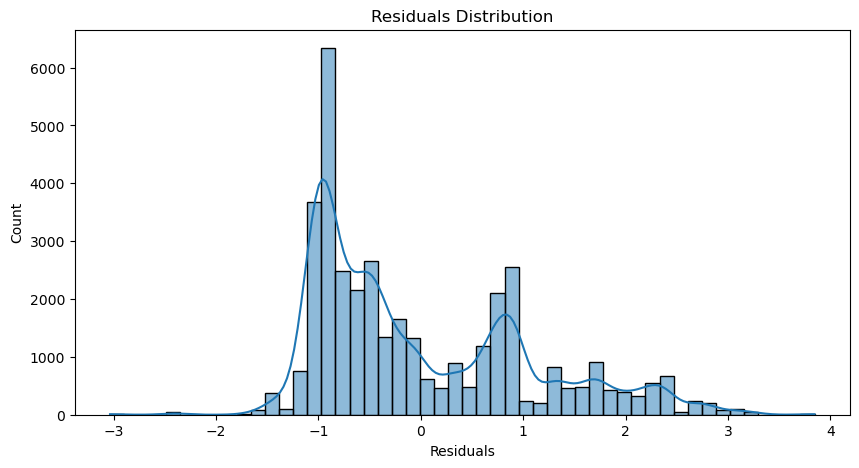

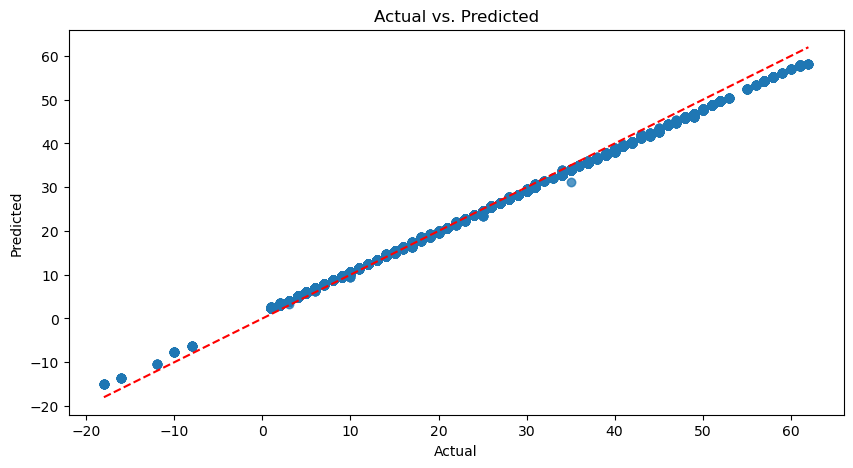

In [67]:
best_model = lgb.LGBMRegressor(**best_params, random_state=42)

# Train the model
best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

# Predictions
y_test_pred = best_model.predict(X_test)

rmse = mean_squared_error(y_test, y_test_pred, squared=False)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R² Score: {r2:.4f}")

# Residual Plot
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel("Residuals")
plt.title("Residuals Distribution")
plt.show()

# Actual vs Predicted Plot
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted")
plt.show()


### Here we got params with perfect model ! may be susp !

Test RMSE: 0.0578
Test MAE: 0.0055
Test R² Score: 1.0000


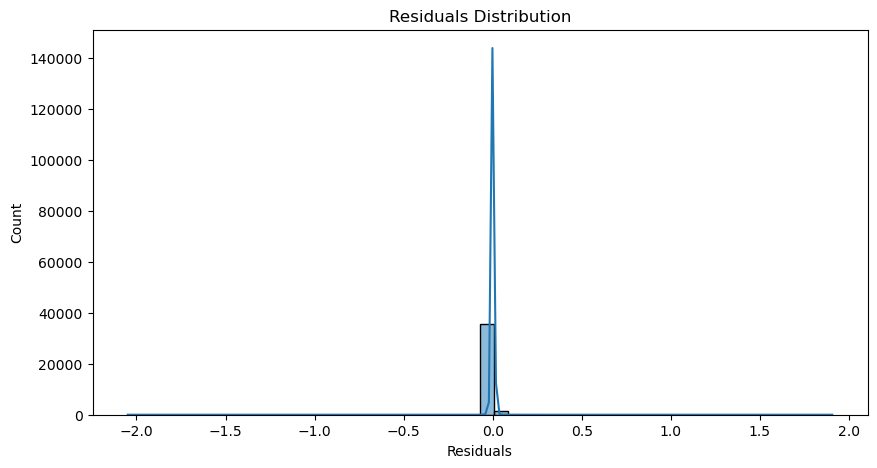

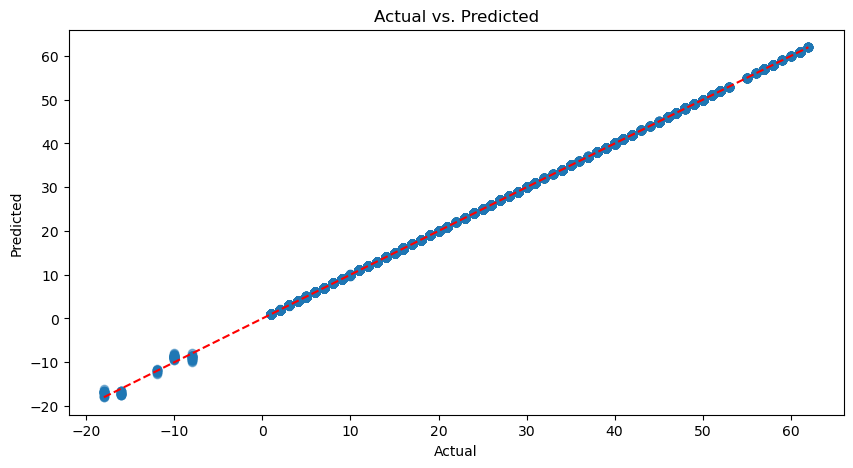

In [28]:
best_model = lgb.LGBMRegressor(**best_params, random_state=42)

# Train the model
best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

# Predictions
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

rmse = mean_squared_error(y_test, y_test_pred, squared=False)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R² Score: {r2:.4f}")

# Residual Plot
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel("Residuals")
plt.title("Residuals Distribution")
plt.show()

# Actual vs Predicted Plot
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted")
plt.show()


## Eval on data 2020

📌 Final Test Data Evaluation:
✅ RMSE: 0.7404
✅ MAE: 0.6247
✅ R² Score: 0.9976


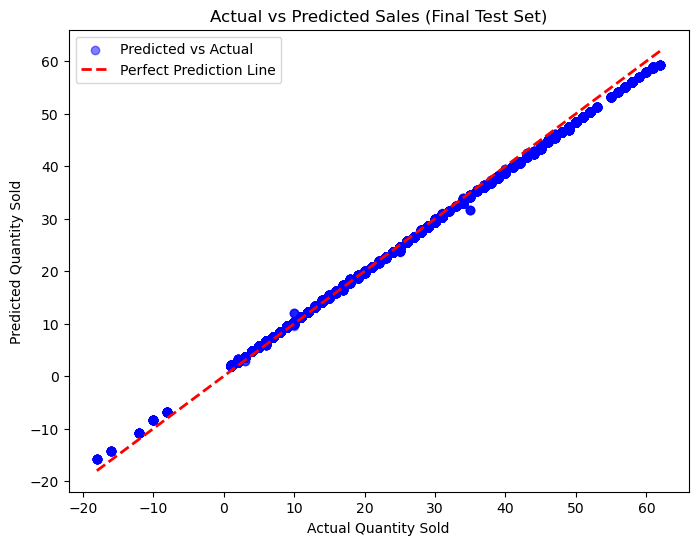

In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# Make predictions
y_final_pred = best_model.predict(X_final_test)

# If dfFinalTest has actual target values, evaluate performance
if target_column in dfFinalTest:
    y_final_actual = dfFinalTest[target_column]
    
    # Compute evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_final_actual, y_final_pred))
    mae = mean_absolute_error(y_final_actual, y_final_pred)
    r2 = r2_score(y_final_actual, y_final_pred)

    print(f"📌 Final Test Data Evaluation:")
    print(f"✅ RMSE: {rmse:.4f}")
    print(f"✅ MAE: {mae:.4f}")
    print(f"✅ R² Score: {r2:.4f}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_final_actual, y_final_pred, alpha=0.5, color="blue", label="Predicted vs Actual")
    plt.plot([min(y_final_actual), max(y_final_actual)], [min(y_final_actual), max(y_final_actual)], 
             color="red", linestyle="dashed", linewidth=2, label="Perfect Prediction Line")
    plt.xlabel("Actual Quantity Sold")
    plt.ylabel("Predicted Quantity Sold")
    plt.title("Actual vs Predicted Sales (Final Test Set)")
    plt.legend()
    plt.show()
    
else:
    print("⚠️ No actual values found in dfFinalTest. Predictions only:")
    print(y_final_pred[:10])  # Display first 10 predictions



# Feature Importance Analysis of the model after fine tunis params

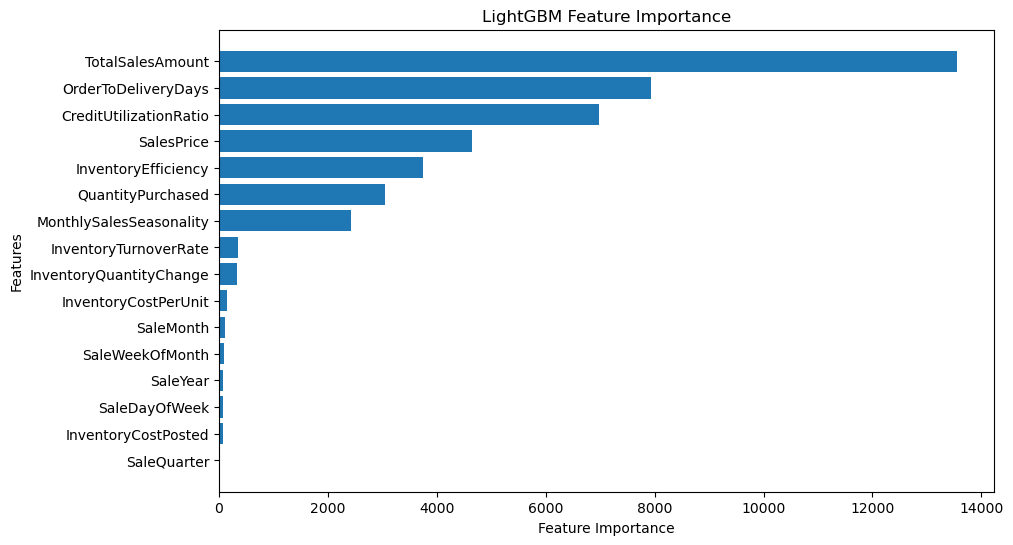

Test RMSE: 0.0022
Test MAE: 0.0005
Test R² Score: 1.0000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_columns)[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("LightGBM Feature Importance")
plt.show()



# Save Model after Fine tuning params 

In [ ]:
import joblib

joblib.dump(best_model, "QSPredection_lgbm_model_finetuned.pkl")
print("Model saved successfully!")


Model saved successfully!
